# Recruit Restaurant Visitor Forecasting
---

## 1.1 Business Problem
---

<h3 style='color: red'> Problem Statement: </h3>

<p>
    Running a thriving local restaurant isn't always as charming as first impressions appear. There are often all sorts of unexpected troubles popping up that could hurt business.

<strong>One common predicament is that restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members.</strong> This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.

Recruit Holdings has unique access to key datasets that could make automated future customer prediction possible. Specifically, Recruit Holdings owns Hot Pepper Gourmet (a restaurant review service), AirREGI (a restaurant point of sales service), and Restaurant Board (reservation log management software).

<strong>In this competition, you're challenged to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.</strong>
</p>

<br>

<h3 style='color:red'> Loss function: RMSLE </h3>

<p>
RMSLE has this unique feature of penalizing underprediction compared to overprediction, which is important in this problem since we don't want the restaurants to be underprepared especially in case of small restaurants. Being over prepared has less effects on the business as the extra resources can be stored.
</p>

few other advantages:

    * RMSLE is unaffected by the outlier values while RMSE does
    * RMSLE focuses on the relational ratio difference between prediction and actual values while RMSE focuses on the difference between their magnitudes.

[read more](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)
    



## 1.2 Database
---

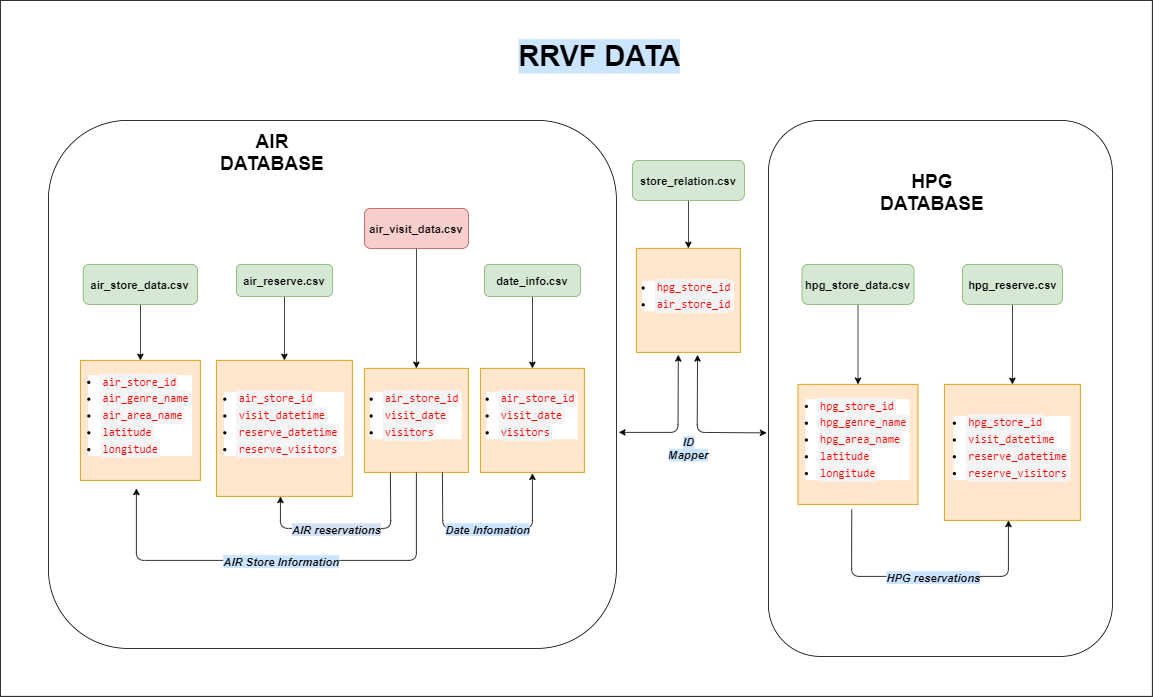

## 1.3 Data Description
---

1. **air_visit_data.csv**: This data contains the historical visits done to AIR registered restaurants

    * **air_store_id** : Unique ID for AIR registered restaurants
    * **visit_date**   : The date of the day
    * **visitors**     : No. of customers visited the restaurant
    
    
2. **air_reserve.csv**: This data contains the reservation done using AIR reservation system
    
    * **air_store_id**       : Unique ID for AIR registered restaurants
    * **visit_datetime**     : The visiting date done through reservation
    * **reserve_datetime**   : The date on which reservation was made.
    * **reserve_visitors**   : No. of visitors for the reservation
    
    
3. **air_store_data**: This data contains the location and restaurant type information for AIR

    * **air_store_id**       : Unique ID for AIR registered restaurants
    * **air_genre_name**     : Type of restaurant
    * **air_area_name**      : area name of the restaurant
    * **latitude**           : lat of the restaurant
    * **longitude**          : long of the restaurant


4. **date_info.csv**: This data contains the visting day calendar information

    * **calendar_date**      : The date
    * **day_of_week**        : what day
    * **holiday_flg**        : if the day was holiday? 1:yes; 0:No


5. **hpg_reserve.csv**: This data contains the reservations done through HPG reservation system

    * **hpg_store_id**       : Unique ID for the restaurants in HPG database
    * **visit_datetime**     : the time of the reservation
    * **reserve_datetime**   : the time the reservation was made
    * **reserve_visitors**   : the number of visitors for that reservation


6. **hpg_store_info.csv**: This data contains the location and restaurant type information for HPG

    * **hpg_store_id**       : Unique ID for HPG registered restaurants
    * **hpg_genre_name**     : Type of restaurant
    * **hpg_area_name**      : area name of the restaurant
    * **latitude**           : lat of the restaurant
    * **longitude**          : long of the restaurant


7. **store_id_relation.csv**: This data contains the mapping for HPG restaurants ID to AIR restaurant ID

    * **hpg_store_id**       : HPG unique ID
    * **air_store_id**       : AIR unique ID


8. **sample_submission.csv**: This is test data for which the predictions has to be done.
    
    * **id**                 : The id is formed by concatenating the air_store_id and visit_date with an underscore
    * **visitors**           : The number of visitors forecasted for the store and date combination
    

## 1.4 Data Preparation
---

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle

sns.set_style('whitegrid')

data_path = os.path.join(os.path.curdir, "Kaggle_Data")
processed_data_path = os.path.join(os.path.curdir, "Processed_Data")
results_path = os.path.join(os.path.curdir, 'results')

In [6]:
# read all the csv files

# air
air_visit_data = pd.read_csv(data_path + "/air_visit_data.csv")
air_visit_data.visit_date = pd.to_datetime(air_visit_data.visit_date)
air_reservation_data = pd.read_csv(data_path + "/air_reserve.csv")
air_store_info = pd.read_csv(data_path + "/air_store_info.csv")

# date info
date_info = pd.read_csv(data_path + "/date_info.csv")
date_info.calendar_date = pd.to_datetime(date_info.calendar_date)

# hpg
hpg_reservation_data = pd.read_csv(data_path + "/hpg_reserve.csv")
hpg_store_info = pd.read_csv(data_path + "/hpg_store_info.csv")
store_id_relation = pd.read_csv(data_path + "/store_id_relation.csv")

# submission
submission = pd.read_csv(data_path + "/sample_submission.csv")

### 1.4.1: Null values checking

In [10]:
def check_null_values(df: pd.DataFrame):
    """
    This function will check for null values in the dataframe
    """
    
    return np.any(df.isna().sum() > 1)


print("Null values check".center(50, "="))
print()
print("air_visit_data:", check_null_values(air_visit_data))
print("air_reservation_data:", check_null_values(air_reservation_data))
print("air_store_info:", check_null_values(air_store_info))
print("date_info:", check_null_values(date_info))
print("hpg_reservation_data:", check_null_values(hpg_reservation_data))
print("hpg_store_info:", check_null_values(hpg_store_info))
print("store_id_relation:", check_null_values(store_id_relation))


================Null values check=================

air_visit_data: False
air_reservation_data: False
air_store_info: False
date_info: False
hpg_reservation_data: False
hpg_store_info: False
store_id_relation: False


### 1.4.2 Data Merge

<strong style="color:red"> air_visit_data.csv and date_info.csv </strong>

In [11]:
# rename the 'calendar_date' column to 'visit date'
date_info.rename(columns={'calendar_date': 'visit_date'}, inplace=True)

# merge the air_visit data and date info on 'visit date'
train_data = pd.merge(air_visit_data, date_info, how='left', on="visit_date")
train_data.sort_values(by='visit_date', inplace=True, ignore_index=True)

train_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_fab092c35776a9b1,2016-01-01,19,Friday,1
1,air_f26f36ec4dc5adb0,2016-01-01,64,Friday,1
2,air_d97dabf7aae60da5,2016-01-01,102,Friday,1
3,air_39dccf7df20b1c6a,2016-01-01,55,Friday,1
4,air_79f528087f49df06,2016-01-01,42,Friday,1


<strong style="color:red"> train_data.csv and air_store_info.csv </strong>

In [12]:
# merge the train data and air_store_info on 'air_store_id'
train_data = pd.merge(train_data, air_store_info, how='left', on="air_store_id")

train_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude
0,air_fab092c35776a9b1,2016-01-01,19,Friday,1,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436
1,air_f26f36ec4dc5adb0,2016-01-01,64,Friday,1,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549
2,air_d97dabf7aae60da5,2016-01-01,102,Friday,1,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669290,139.707056
3,air_39dccf7df20b1c6a,2016-01-01,55,Friday,1,Izakaya,Hyōgo-ken Takarazuka-shi Tōyōchō,34.799767,135.360073
4,air_79f528087f49df06,2016-01-01,42,Friday,1,Western food,Tōkyō-to Suginami-ku Asagayaminami,35.699566,139.636438


<strong style="color:red"> train_data.csv and air_reservation_info.csv </strong>

In [13]:
# date time conversion
air_reservation_data.visit_datetime = pd.to_datetime(air_reservation_data.visit_datetime)
air_reservation_data.reserve_datetime = pd.to_datetime(air_reservation_data.reserve_datetime)

# add the hours gap difference between visit time to reservation time
air_reserve_diff = air_reservation_data.visit_datetime - air_reservation_data.reserve_datetime
air_reserve_diff = air_reserve_diff / np.timedelta64(1, 'h')
air_reservation_data['reservation_gap'] = air_reserve_diff

# add the visit date column
air_reservation_data['visit_date'] = air_reservation_data.visit_datetime.dt.date

In [14]:
air_reservation_data.to_csv(processed_data_path + "/processed_air_reserve.csv", index=False)
air_reservation_data.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,reservation_gap,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,3.0,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,0.0,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,0.0,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,4.0,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,19.0,2016-01-01


In [15]:
# we need to get total reservation visitors on the visit_date per restaurant
reservations_per_day = air_reservation_data.groupby(by=['air_store_id', 'visit_date'], as_index=False).sum()
reservations_per_day.visit_date = pd.to_datetime(reservations_per_day.visit_date)

# merge train_data and the total reservations done on the visit date per store id
train_data.visit_date = pd.to_datetime(train_data.visit_date)
train_data = pd.merge(train_data, reservations_per_day, how='left', on=['visit_date', 'air_store_id', ])
train_data.fillna(0, inplace=True)

# fill no reservation with zero
train_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,reservation_gap
0,air_fab092c35776a9b1,2016-01-01,19,Friday,1,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436,0.0,0.0
1,air_f26f36ec4dc5adb0,2016-01-01,64,Friday,1,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,0.0,0.0
2,air_d97dabf7aae60da5,2016-01-01,102,Friday,1,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669290,139.707056,0.0,0.0
3,air_39dccf7df20b1c6a,2016-01-01,55,Friday,1,Izakaya,Hyōgo-ken Takarazuka-shi Tōyōchō,34.799767,135.360073,0.0,0.0
4,air_79f528087f49df06,2016-01-01,42,Friday,1,Western food,Tōkyō-to Suginami-ku Asagayaminami,35.699566,139.636438,0.0,0.0


In [ ]:
train_data.to_csv(processed_data_path + "/processed_air_data.csv")

<strong style="color:red"> train_data.csv and hpg_reservation.csv </strong>

In [16]:
## we need to extract the reservation made to the same AIR restaurants through HPG reservation system

# get the air_store_id's reservations done throught HPG reservation
hpg_database = pd.merge(hpg_reservation_data, store_id_relation, how='inner', on='hpg_store_id')

# add their store_information
hpg_database = pd.merge(hpg_database, hpg_store_info, how='left', on='hpg_store_id')

# add the reservation time diff
hpg_database.visit_datetime = pd.to_datetime(hpg_database.visit_datetime)
hpg_database.reserve_datetime = pd.to_datetime(hpg_database.reserve_datetime)
hpg_reserve_diff = hpg_database.visit_datetime - hpg_database.reserve_datetime
hpg_reserve_diff = hpg_reserve_diff / np.timedelta64(1, 'h')
hpg_database['hpg_reserve_gap'] = hpg_reserve_diff
hpg_database['hpg_visit_date'] = hpg_database.visit_datetime.dt.date


In [ ]:
hpg_database.to_csv(processed_data_path + "/processed_hpg_data.csv")

In [17]:
# we need to get total reservation visitors on the visit_date per restaurant
hpg_reservations_per_day = hpg_database.groupby(by=['air_store_id', 'hpg_visit_date'], as_index=False)[['reserve_visitors', 'hpg_reserve_gap']].sum()
hpg_reservations_per_day.rename(columns={'hpg_visit_date': 'visit_date'}, inplace=True)
hpg_reservations_per_day.visit_date = pd.to_datetime(hpg_reservations_per_day.visit_date)

# merge train_data and the total reservations done on the visit date per store id
train_data = pd.merge(train_data, hpg_reservations_per_day, how='left', on=['visit_date', 'air_store_id'], suffixes=("_air", "_hpg"))
train_data.fillna(0, inplace=True)

# fill no reservation with zero
train_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,reserve_visitors_air,reservation_gap,reserve_visitors_hpg,hpg_reserve_gap
0,air_fab092c35776a9b1,2016-01-01,19,Friday,1,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436,0.0,0.0,0.0,0.0
1,air_f26f36ec4dc5adb0,2016-01-01,64,Friday,1,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,0.0,0.0,0.0,0.0
2,air_d97dabf7aae60da5,2016-01-01,102,Friday,1,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669290,139.707056,0.0,0.0,0.0,0.0
3,air_39dccf7df20b1c6a,2016-01-01,55,Friday,1,Izakaya,Hyōgo-ken Takarazuka-shi Tōyōchō,34.799767,135.360073,0.0,0.0,0.0,0.0
4,air_79f528087f49df06,2016-01-01,42,Friday,1,Western food,Tōkyō-to Suginami-ku Asagayaminami,35.699566,139.636438,0.0,0.0,0.0,0.0


In [18]:
train_data.to_csv(processed_data_path + "/processed_train_data.csv", index=False)

<strong style="color:red"> submission.csv </strong>

In [19]:
submission['air_store_id'] = submission.id.str[:20]
submission['visit_date'] = submission.id.str[21:]
submission.head()

,id,visitors,air_store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27


In [ ]:
submission.to_csv(processed_data_path + "/processed_test_data.csv", index=False)

In [20]:
print()
print("Train Data information".center(50, "="))
print()
print("Train dataset size: ", train_data.shape)
print("Total unique restaurants", len(train_data.air_store_id.unique()))
print("Total unique restaurant genre: ", len(train_data.air_genre_name.unique()))
print(f"Average visitors: {train_data.visitors.mean():.2f}")
print(f"Median visitors: {train_data.visitors.median():.2f}")
print("The average/median vistors for restaurants is around 18-20. Most of these restaurants are small")
print("No of days data:", len(train_data.visit_date.unique()))
print(f"Date span: {train_data.visit_date.min().date()} - {train_data.visit_date.max().date()}")

print()
print("Test Data information".center(50, "="))
print()
print("Total unique restarants: ", len(submission.air_store_id.unique()))
print("No of days to be predicted: ",len(submission.visit_date.unique()))
submission.visit_date = pd.to_datetime(submission.visit_date)
print(f"Date span: {submission.visit_date.min().date()} - {submission.visit_date.max().date()}")


==============Train Data information==============

Train dataset size:  (252108, 13)
Total unique restaurants 829
Total unique restaurant genre:  14
Average visitors: 20.97
Median visitors: 17.00
The average/median vistors for restaurants is around 18-20. Most of these restaurants are small
No of days data: 478
Date span: 2016-01-01 - 2017-04-22

==============Test Data information===============

Total unique restarants:  821
No of days to be predicted:  39
Date span: 2017-04-23 - 2017-05-31


## 1.5 EDA
---

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
sns.set_style('darkgrid')

%matplotlib inline

In [3]:
train_data = pd.read_csv(processed_data_path + "/processed_train_data.csv")
# submission = pd.read_csv(processed_data_path + "/processed_test_data.csv")
train_data.visit_date = pd.to_datetime(train_data.visit_date)

#### Visitors trend across the days

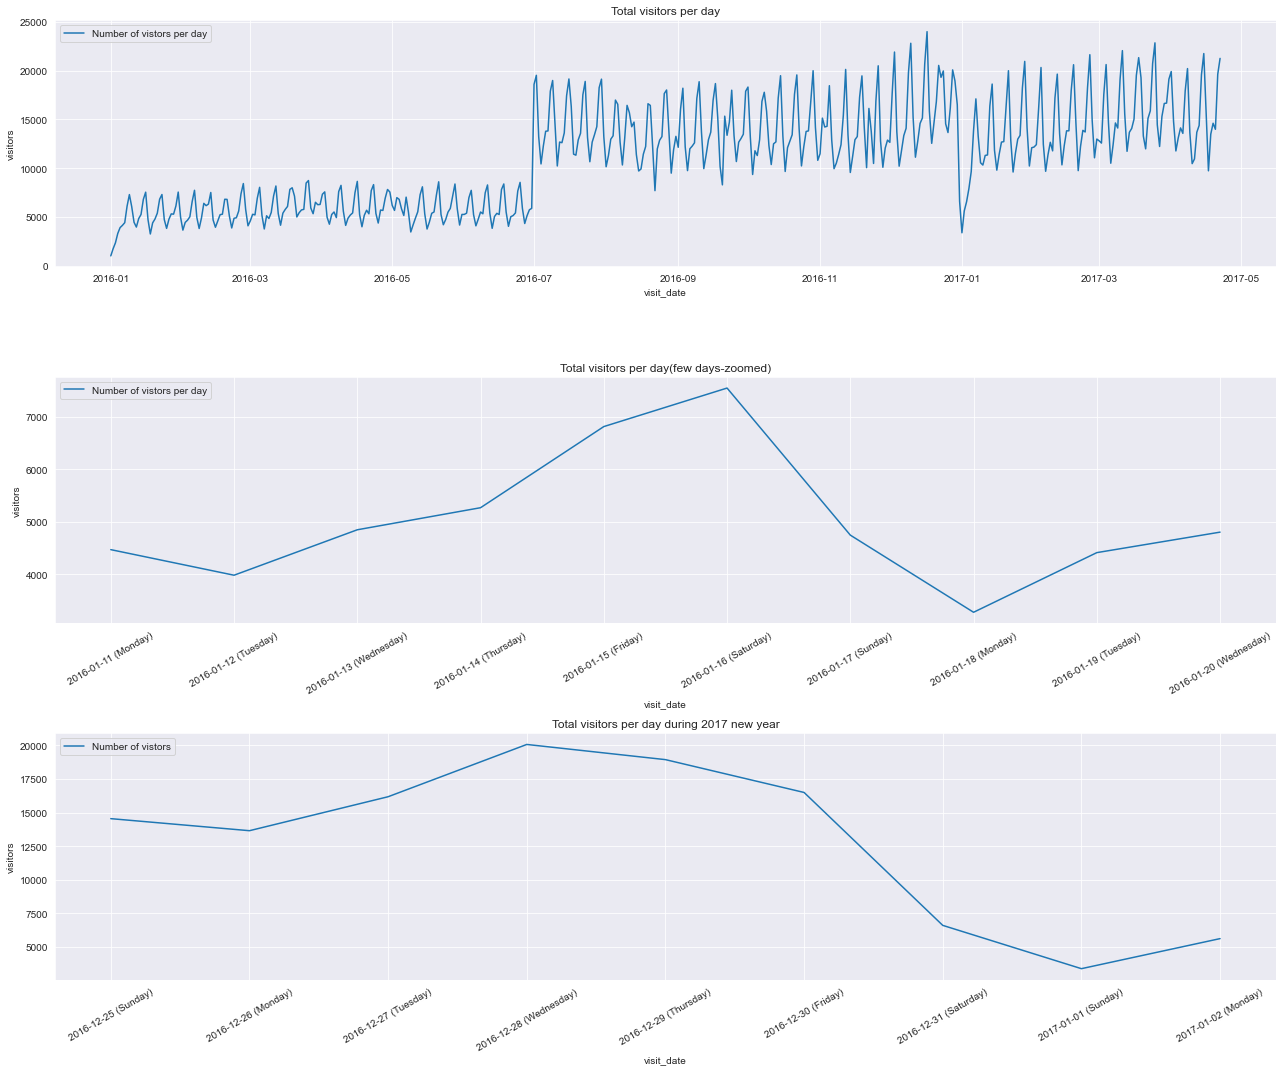

In [4]:
# per day visitors
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(311)

temp = train_data.groupby("visit_date").visitors.sum()

sns.lineplot(temp.index, temp, ax=ax1, label="Number of vistors per day")
plt.title("Total visitors per day")
plt.legend(loc='upper left')


ax2 = fig.add_subplot(312)
sns.lineplot(temp.index[10:20], temp[10:20], ax=ax2, label="Number of vistors per day")
ax2.set_xticklabels(temp[10:20].index.strftime("%Y-%m-%d (%A)"), rotation=30)
plt.legend(loc='upper left')
plt.title("Total visitors per day(few days-zoomed)")


temp = temp.loc['2016-12-25': '2017-01-02']

ax3 = fig.add_subplot(313)
sns.lineplot(temp.index, temp, ax=ax3, label="Number of vistors")
ax3.set_xticklabels(temp.index.strftime("%Y-%m-%d (%A)"), rotation=30)
plt.title("Total visitors per day during 2017 new year")
plt.legend(loc='upper left')
plt.tight_layout()
# plt.show()
plt.savefig("Visitors_trend_across_the_days.png", bbox_inches='tight')


* `It can be observed that there is seasonality for visitors variable. Around July 2016, there is a sharp rise is in visitors, this could be due to more restaurants being added to the database.`

* `The seasonality across training data is corresponding to the weekly cycle. As the weekend nears, there is rise in visitors for AIR restaurants.`

* `There is also sharp dip in visitors during 2017-01-01, which is due to New year celebration.`


#### Visitors trend during golden week

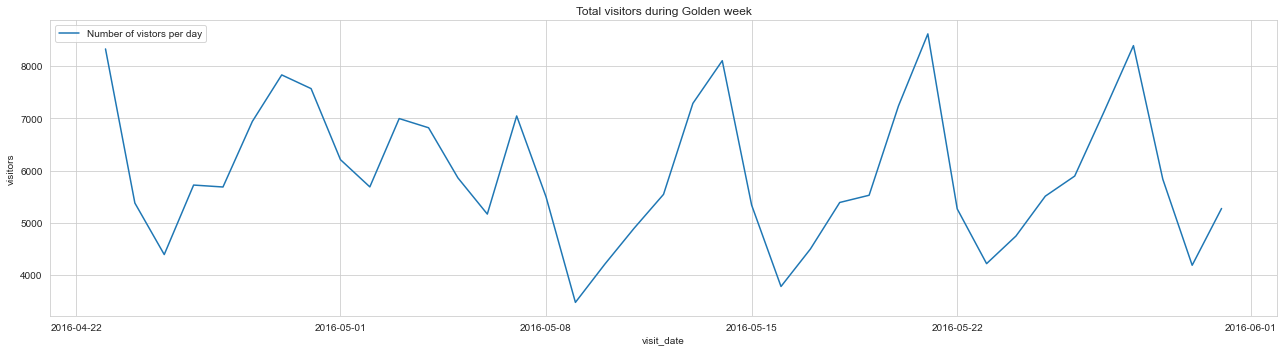

In [27]:
# per day visitors
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(111)

temp = train_data.groupby("visit_date").visitors.sum()

# the golden week is between april and may 
temp = temp.loc['2016-04-23': '2016-05-31']

sns.lineplot(temp.index, temp, ax=ax1, label="Number of vistors per day")
plt.title("Total visitors during Golden week")
plt.legend(loc='upper left')
plt.tight_layout()
# plt.show()
plt.savefig("Visitors_trend_during_golden_week.png", bbox_inches='tight')

* `The golden week(April 29 - May 05) effect can be seen on visitors. There is consistency in visitors for AIR restaurants.`

* `After the golden week(May 06), there is dip in visitors, even on the weekend. The next week the weekly trend continues.`

* `Since the test data set spans around the golden week, this exception needs to be handled.`

#### Average visitors by week/month for the year 2016-17

C:\Users\sanjayc\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sanjayc\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


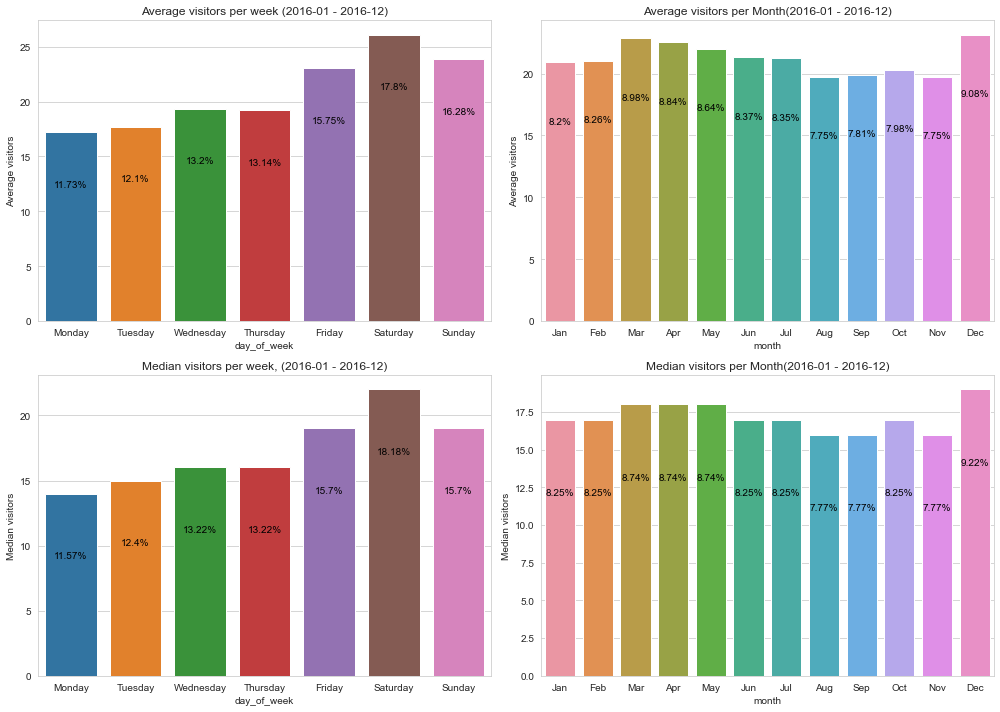

In [47]:
# average per week, per month
fig = plt.figure(figsize=(14,10))

ax1 = fig.add_subplot(221)
# order the days
# https://stackoverflow.com/a/35194104/9103175
train_data.day_of_week = pd.Categorical(train_data['day_of_week'], categories=
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True)

train_2016_data = train_data.loc[train_data.visit_date.dt.year == 2016]

temp = train_2016_data.groupby("day_of_week", as_index=False).visitors.mean()
temp = temp.sort_index()
temp['percent'] =  (temp.visitors / temp.visitors.sum()) * 100

g = sns.barplot(temp.day_of_week, temp.visitors, ax=ax1)

for index, row in temp.iterrows():
    g.text(index, row.visitors-5, str(np.round(row.percent,2)) + "%", color='black', ha="center")

plt.title("Average visitors per week (2016-01 - 2016-12)")
plt.ylabel("Average visitors")

train_2016_data.loc[:, 'month'] = train_2016_data.loc[:, 'visit_date'].dt.month
temp = train_2016_data.groupby("month", as_index=False).visitors.mean()
temp['percent'] =  (temp.visitors / temp.visitors.sum()) * 100

ax2 = fig.add_subplot(222)
g = sns.barplot(temp.month, temp.visitors, ax=ax2)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for index, row in temp.iterrows():
    g.text(index, row.visitors-5, str(np.round(row.percent,2)) + "%", color='black', ha="center")

    plt.title("Average visitors per Month(2016-01 - 2016-12)")
x_labels = [ months[i] for i in temp.index]
ax2.set_xticklabels(x_labels)
plt.ylabel("Average visitors")


# Median per week, per month
ax3 = fig.add_subplot(223)
temp = train_2016_data.groupby("day_of_week", as_index=False).visitors.median()
temp = temp.sort_index()
temp['percent'] =  (temp.visitors / temp.visitors.sum()) * 100

g = sns.barplot(temp.day_of_week, temp.visitors, ax=ax3)

for index, row in temp.iterrows():
    g.text(index, row.visitors-5, str(np.round(row.percent,2)) + "%", color='black', ha="center")

plt.title("Median visitors per week, (2016-01 - 2016-12)")
plt.ylabel("Median visitors")

train_2016_data.loc[:, 'month'] = train_2016_data.loc[:, 'visit_date'].dt.month
temp = train_2016_data.groupby("month", as_index=False).visitors.median()
temp['percent'] =  (temp.visitors / temp.visitors.sum()) * 100

ax4 = fig.add_subplot(224)
g = sns.barplot(temp.month, temp.visitors, ax=ax4)

for index, row in temp.iterrows():
    g.text(index, row.visitors-5, str(np.round(row.percent,2)) + "%", color='black', ha="center")

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.title("Median visitors per Month(2016-01 - 2016-12)")
x_labels = [ months[i] for i in temp.index]
ax4.set_xticklabels(x_labels)
plt.ylabel("Median visitors")
plt.tight_layout()
# plt.show()
plt.savefig("Average_visitors_by_weekday_monthly_2016", bbox_inches='tight')

* `Saturday seems to be popular choice of day for restaurant dinner. Friday being second. This seems obvious given that Friday is last working day and Saturday, Sunday are holidays`

* `December gets highest visitors due to New year celebrations. March, April and May have consistent visitors`
* `There is a significant difference in mean and median values of visitors. There is presence of some outliers which needs to dealt`

#### Vistors vs  holiday

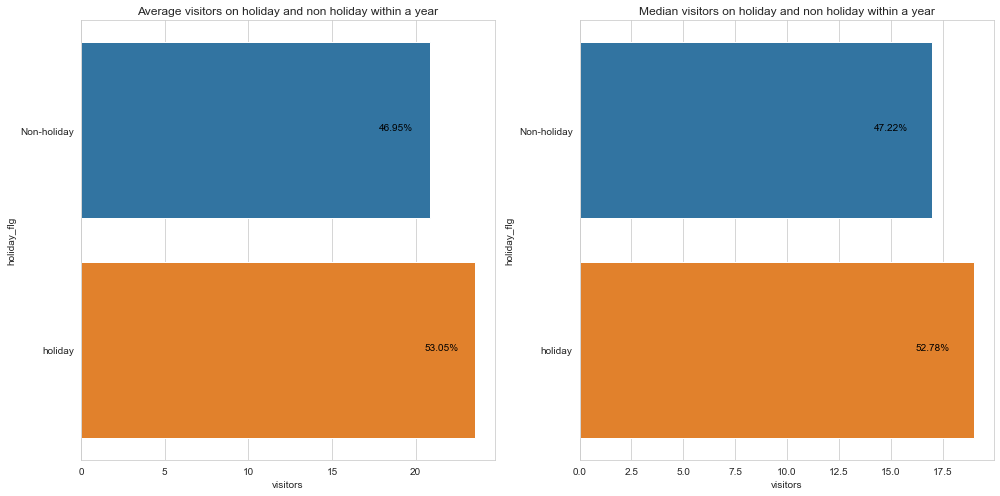

In [29]:
# average vistors on holiday and non holiday
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121)

temp = train_2016_data.groupby("holiday_flg", as_index=False).visitors.mean()
temp['percent'] = (temp.visitors / temp.visitors.sum()) * 100

g = sns.barplot(temp.visitors, temp.holiday_flg, ax=ax1, orient='h')

for index, row in temp.iterrows():
    g.text(row.visitors-2, index, str(np.round(row.percent, 2)) + "%", color='black', ha="center")
labels = ['Non-holiday', 'holiday']
ax1.set_yticklabels([labels[i] for i in temp.index])
plt.title("Average visitors on holiday and non holiday within a year")

temp = train_2016_data.groupby("holiday_flg", as_index=False).visitors.median()
temp['percent'] = (temp.visitors / temp.visitors.sum()) * 100
ax2 = fig.add_subplot(122)
g = sns.barplot(temp.visitors, temp.holiday_flg, ax=ax2, orient='h')
for index, row in temp.iterrows():
    g.text(row.visitors-2, index, str(np.round(row.percent, 2)) + "%", color='black', ha="center")

labels = ['Non-holiday', 'holiday']
ax2.set_yticklabels([labels[i] for i in temp.index])
plt.title("Median visitors on holiday and non holiday within a year")

plt.tight_layout()

# plt.show()

plt.savefig("Average_visitors_by_holiday_&_non_holiday", bbox_inches='tight')

* `For obvious reasons, the visitors are high on holidays in comparison to visitors on non-holiday`

#### Visitors trend on weekends vs weekdays

In [31]:
# weekend_flag 
train_data['weekend_flag'] = train_data.day_of_week.isin(['Saturday','Sunday']).astype(int)
train_data.head(2)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,reserve_visitors_air,reservation_gap,reserve_visitors_hpg,hpg_reserve_gap,weekend_flag
0,air_fab092c35776a9b1,2016-01-01,19,Friday,1,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436,0.0,0.0,0.0,0.0,0
1,air_f26f36ec4dc5adb0,2016-01-01,64,Friday,1,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,0.0,0.0,0.0,0.0,0


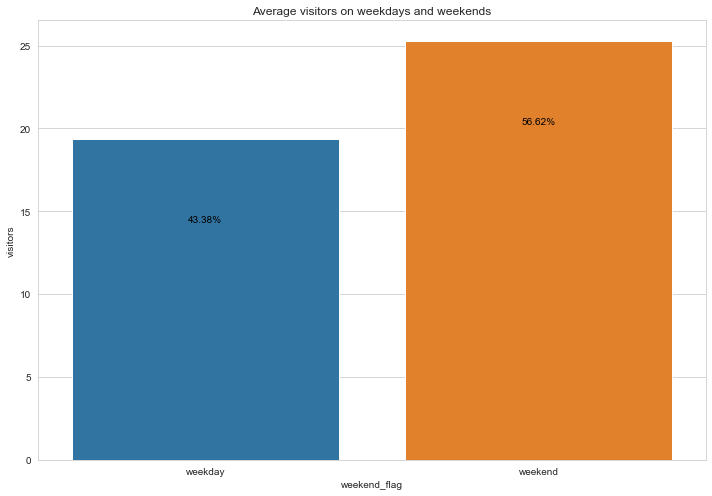

In [32]:
# average vistors on weekend and weekdays
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(111)

temp = train_data.groupby("weekend_flag", as_index=False).visitors.mean()
temp['percent'] = (temp.visitors / temp.visitors.sum()) * 100
g = sns.barplot(temp.weekend_flag, temp.visitors, ax=ax1)

for index, row in temp.iterrows():
    g.text(index, row.visitors-5, str(np.round(row.percent, 2)) + "%", color='black', ha='center')

labels = ['weekday', 'weekend']
ax1.set_xticklabels([labels[i] for i in temp.index])
plt.title("Average visitors on weekdays and weekends")

plt.tight_layout()
# plt.show()
plt.savefig("Average_visitors_by_weekdays_weekends", bbox_inches='tight')

* `weekends have more visitors in comparison to weekdays`

#### Visitors trend if next day is holiday

In [33]:
# next_day_holiday_flag 
train_data['nxt_day_holiday_flg'] = train_data.day_of_week.isin(['Friday','Saturday']).astype(int)
train_data.head(2)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,reserve_visitors_air,reservation_gap,reserve_visitors_hpg,hpg_reserve_gap,weekend_flag,nxt_day_holiday_flg
0,air_fab092c35776a9b1,2016-01-01,19,Friday,1,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436,0.0,0.0,0.0,0.0,0,1
1,air_f26f36ec4dc5adb0,2016-01-01,64,Friday,1,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,0.0,0.0,0.0,0.0,0,1


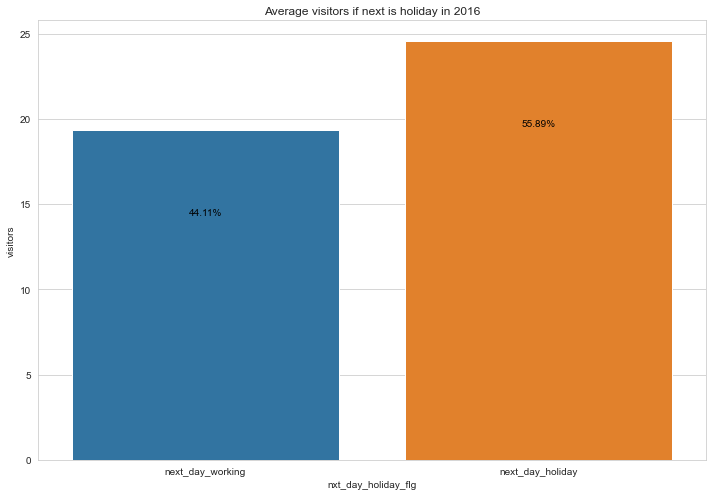

In [34]:
# average vistors if next day is holiday
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(111)

train_2016_data = train_data.loc[train_data.visit_date.dt.year == 2016]

temp = train_2016_data.groupby("nxt_day_holiday_flg", as_index=False).visitors.mean()
temp['percent'] = (temp.visitors / temp.visitors.sum()) * 100

g = sns.barplot(temp.nxt_day_holiday_flg, temp.visitors, ax=ax1)
for index, row in temp.iterrows():
    g.text(index, row.visitors-5, str(np.round(row.percent, 2)) + "%", color='black', ha='center')

labels = ['next_day_working', 'next_day_holiday']
ax1.set_xticklabels([labels[i] for i in temp.index])
plt.title("Average visitors if next is holiday in 2016")

plt.tight_layout()
# plt.show()
plt.savefig("Average_visitors_by_next_day_holiday", bbox_inches='tight')

* `Visitors are high not only during holidays, but also if next day is holiday`

#### reservations done through AIR/HPG system

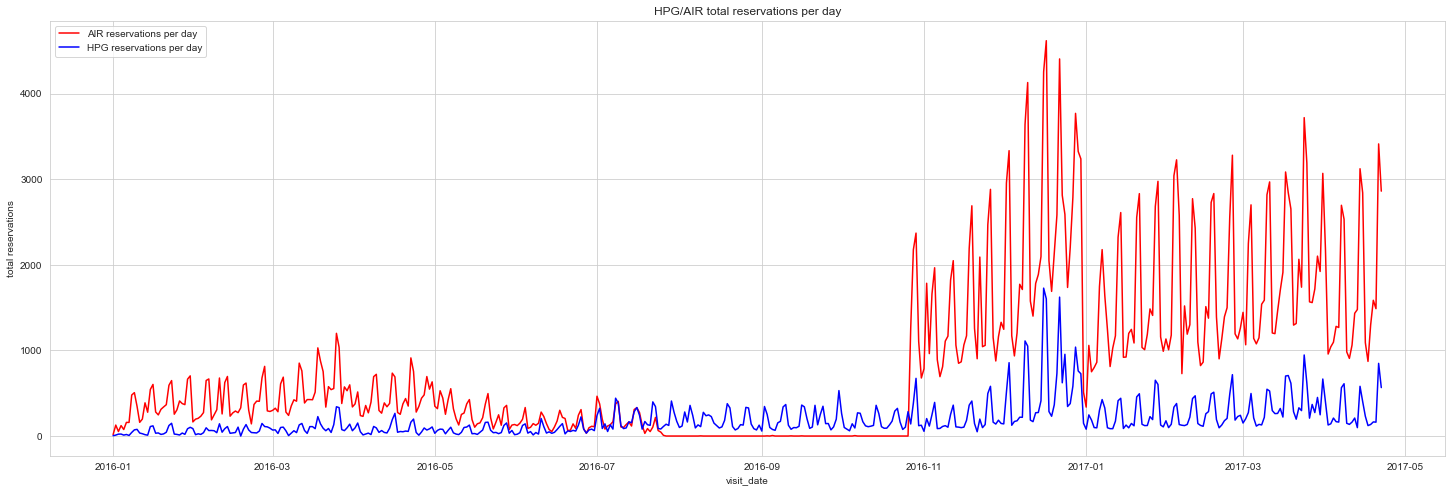

In [35]:
# reservations
# total reservations per day
temp = train_data.groupby("visit_date").reserve_visitors_air.sum()
temp2 = train_data.groupby("visit_date").reserve_visitors_hpg.sum()

fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(111)

sns.lineplot(temp.index, temp, label="AIR reservations per day", color='r', ax=ax)
sns.lineplot(temp2.index, temp2, label="HPG reservations per day", color='b', ax=ax)
plt.legend(loc='upper left')
plt.ylabel("total reservations")

plt.title("HPG/AIR total reservations per day")
# plt.show()
plt.savefig("reservations_trend_accross_data", bbox_inches='tight')

* `AIR reservations have missing data between 2016-07 to 2016-11`
* `Both reservations are high during the December and drop on the 2017-01-01`
* `The reservations in both systems seems to be more in 2017 especially in AIR system compared to 2016`

#### Does reservations has any effect on visitors?

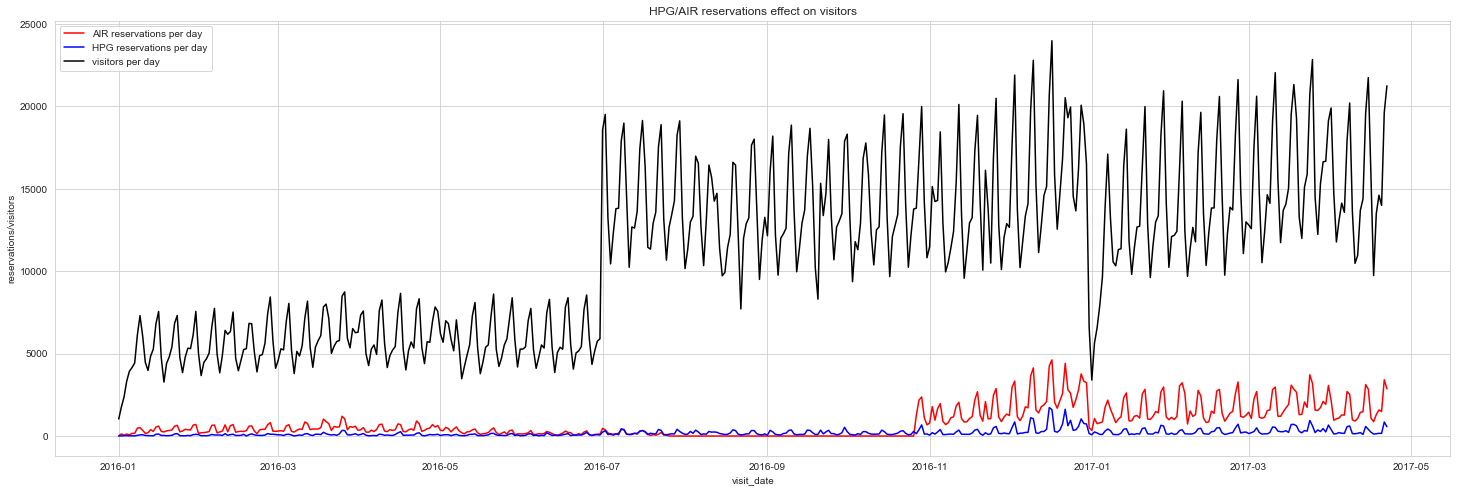

In [36]:
# reservations
# total reservations per day
temp = train_data.groupby("visit_date").reserve_visitors_air.sum()
temp2 = train_data.groupby("visit_date").reserve_visitors_hpg.sum()
temp3 = train_data.groupby("visit_date").visitors.sum()

fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(111)

sns.lineplot(temp.index, temp, label="AIR reservations per day", color='r', ax=ax)
sns.lineplot(temp2.index, temp2, label="HPG reservations per day", color='b', ax=ax)
sns.lineplot(temp3.index, temp3, label="visitors per day", color='black', ax=ax)
plt.legend(loc='upper left')
plt.ylabel("reservations/visitors")

plt.title("HPG/AIR reservations effect on visitors")
# plt.show()
plt.savefig("reservations_vs_visitors", bbox_inches='tight')

* `The reservations do have positive effect on visitors. Around 2016-11, it can be observed that visitors are spiking with reservations`
* `This observation can also mean that most of the reservations are done for single day`
* `Also visitor number is higher in comparison with reservations. This is obvious as most prefer to walk in than reservations. Also the reservations are higher in December. This is due to busy restaurants on new years eve and its better to reserve than walking in`

#### Reservation time

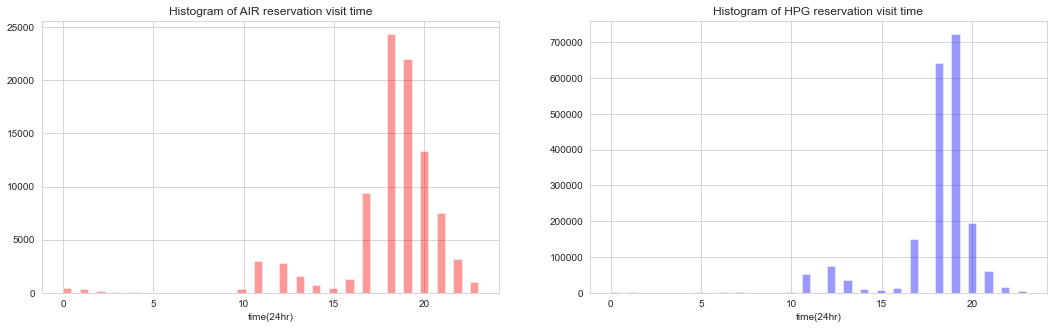

In [43]:
air_reservation_data.visit_datetime = pd.to_datetime(air_reservation_data.visit_datetime)
air_reservation_data.reserve_datetime = pd.to_datetime(air_reservation_data.reserve_datetime)

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(121)

sns.distplot(air_reservation_data.visit_datetime.dt.hour, color='red', kde=False, ax=ax1)
plt.title("Histogram of AIR reservation visit time")
plt.xlabel("time(24hr)")

ax2 = fig.add_subplot(122)
hpg_reservation_data.visit_datetime = pd.to_datetime(hpg_reservation_data.visit_datetime)
hpg_reservation_data.reserve_datetime = pd.to_datetime(hpg_reservation_data.reserve_datetime)
sns.distplot(hpg_reservation_data.visit_datetime.dt.hour, color='blue', kde=False, ax=ax2)
plt.title("Histogram of HPG reservation visit time")
plt.xlabel("time(24hr)")
# plt.show()

# plt.show()
plt.savefig("reservation_time", bbox_inches='tight')

* `Both in AIR and HPG, reservations are high for dinner time`
* `reservations on HPG system are lot higher in comparison with AIR`

#### Which genre is popular among visitors?

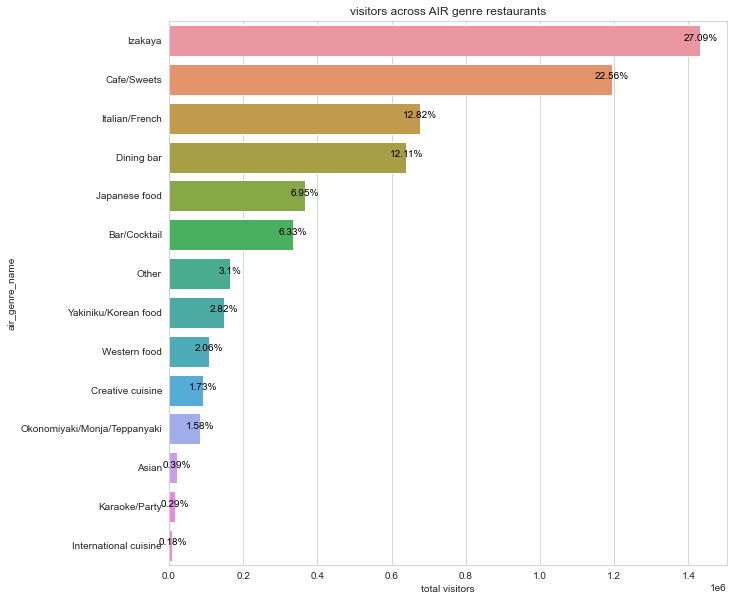

In [38]:
fig, ax = plt.subplots(figsize=(10,10))

temp = train_data.groupby("air_genre_name", as_index=False).visitors.sum()
temp.sort_values(by='visitors', inplace=True, ascending=False)
temp = temp.reset_index()
temp['percent'] = (temp.visitors / temp.visitors.sum()) * 100

g = sns.barplot(x=temp.visitors, y=temp.air_genre_name, ax=ax)
for index, row in temp.iterrows():
    g.text(row.visitors - 7, index, str(np.round(row.percent, 2)) + '%', ha='center', color='black')
plt.title("visitors across AIR genre restaurants")
plt.xlabel("total visitors")
# plt.show()
plt.savefig("visitors_vs_Genre", bbox_inches='tight')

* `'IZAKAYA' seem genre is popular among visitors. A google search reveals that 'IZAKAYA' are japanese bars which serve alcohol and snacks and is common choice for after work drinking`

* `after work or morning cafes/sweets has second highest visitors`

* `Though reservation is highest for Dinner time, the visitor count for food restaurants is less`

* `International cuisine has the least visitors`

####  area wise, genre wise restaurant count

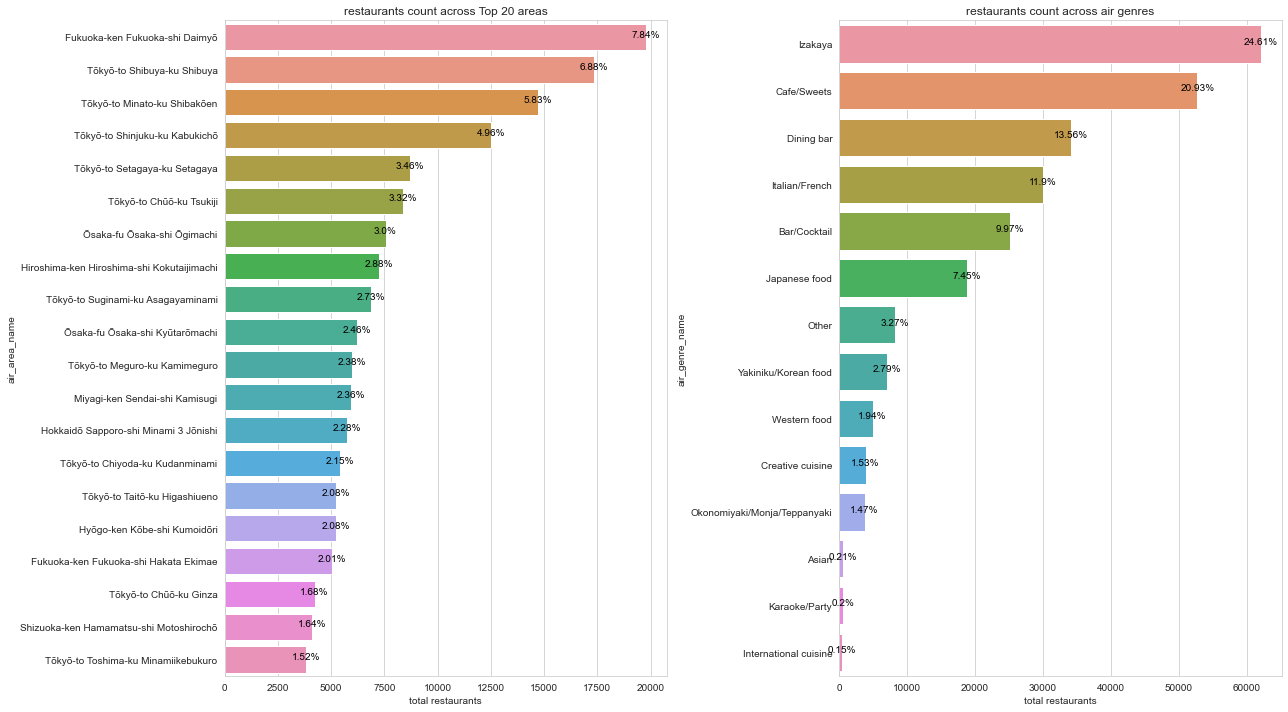

In [39]:
fig = plt.figure(figsize=(18,10))

# top 20
temp = train_data.groupby("air_area_name", as_index=False).air_store_id.count()
temp.sort_values(by='air_store_id', inplace=True, ascending=False)
temp.reset_index(inplace=True)
temp['percent'] = (temp.air_store_id / temp.air_store_id.sum()) * 100

ax1 = fig.add_subplot(121)
g = sns.barplot(x=temp[:20].air_store_id, y=temp.air_area_name[:20], ax=ax1)
for index, row in temp[:20].iterrows():
    g.text(row.air_store_id - 7, index, str(np.round(row.percent, 2)) + '%', ha='center', color='black')
plt.title("restaurants count across Top 20 areas")
plt.xlabel("total restaurants")

temp = train_data.groupby("air_genre_name", as_index=False).air_store_id.count()
temp.sort_values(by='air_store_id', inplace=True, ascending=False)
temp.reset_index(inplace=True)
temp['percent'] = (temp.air_store_id / temp.air_store_id.sum()) * 100

ax2 = fig.add_subplot(122)
g = sns.barplot(x=temp.air_store_id, y=temp.air_genre_name, ax=ax2)

for index, row in temp[:20].iterrows():
    g.text(row.air_store_id - 7, index, str(np.round(row.percent, 2)) + '%', ha='center', color='black')

plt.title("restaurants count across air genres")
plt.xlabel("total restaurants")

plt.tight_layout()
# plt.show()
plt.savefig("area_genre_popluraity", bbox_inches='tight')

* `Fukouka has the most restaurants followed by many areas around tokyo`
* `Izakaya, Cafe/sweets types of restaurants are high in numbers. No wonder the visitors count are high among these types`

#### Diff genre restaurants area wise

In [26]:
temp = train_data.groupby(['air_area_name', 'air_genre_name'], as_index=True).air_store_id.count()
temp = temp.unstack(fill_value=0)
# temp = (temp.T / temp.T.sum()).T

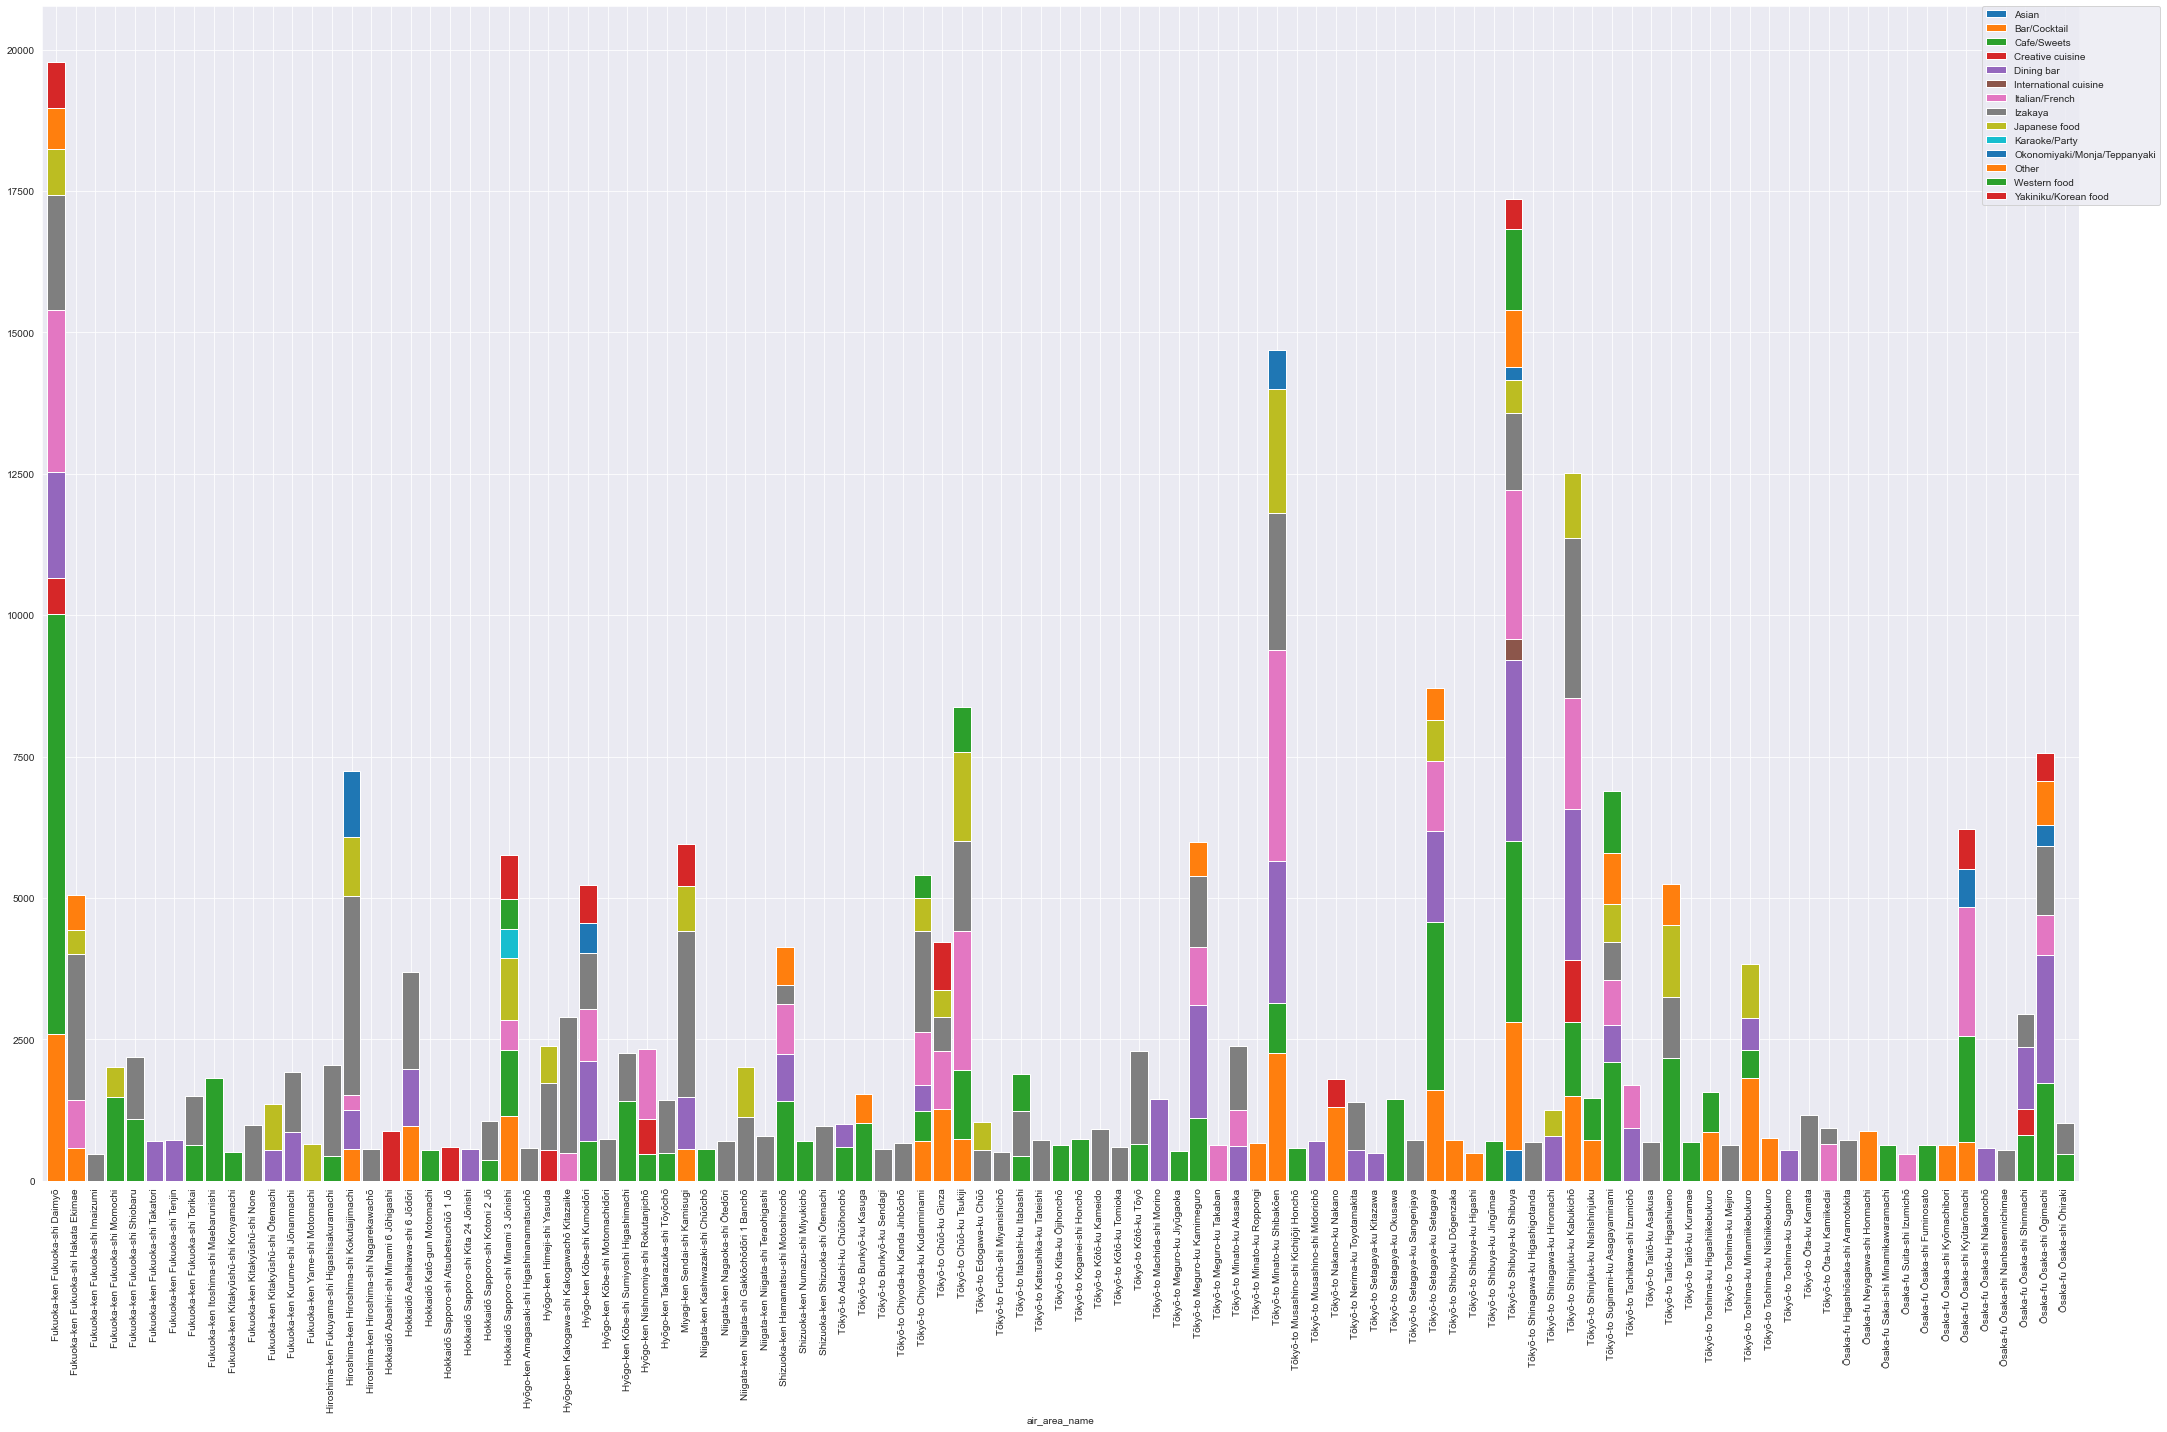

In [27]:
temp.plot(kind='bar', stacked=True, figsize=(30, 20), width=0.9)
# https://stackoverflow.com/a/43439132/9103175
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.tight_layout()
plt.show()

* `Daimyo is the most famous place with 19k restaurants. Interestingly Cafe/sweets genre(second fav among visitors) dominate this area in comparison to Izakaya.`
* `Cafe/sweets and Izakaya seems to be most common in almost all the areas followed by Italian/French`

#### area wise restaurant cluster

In [8]:
import folium
from folium.plugins import MarkerCluster

japan_map = folium.Map(location=[36.2048, 138.2529], tiles="Stamen Toner", zoom_start=6, min_zoom=4)
marker_cluster = MarkerCluster().add_to(japan_map)

for row in air_store_info.values:
    
    folium.Marker(location=[row[-2], row[-1]], popup=f"{row[0]} - {row[1]} - {row[2]}").add_to(marker_cluster)

japan_map

* `From the map, the Fukuoka has highest restaurants around one single place. Hence the high number of visitors.`
* `while the Tokyo area has overall high number of restaurants, they form different clusters spread in different areas of Tokyo. Hence the visitors are spread out. `
* `Area name could be very important information is determining the visitors.`
* `Osaka is second most popular and reasturants are spread out`
* `Also we can see that more the restaurants in the area more the visitors count. Area wise resturant count could be useful`

In [9]:
japan_map.save("japan.html")

#### visitors trend across genre

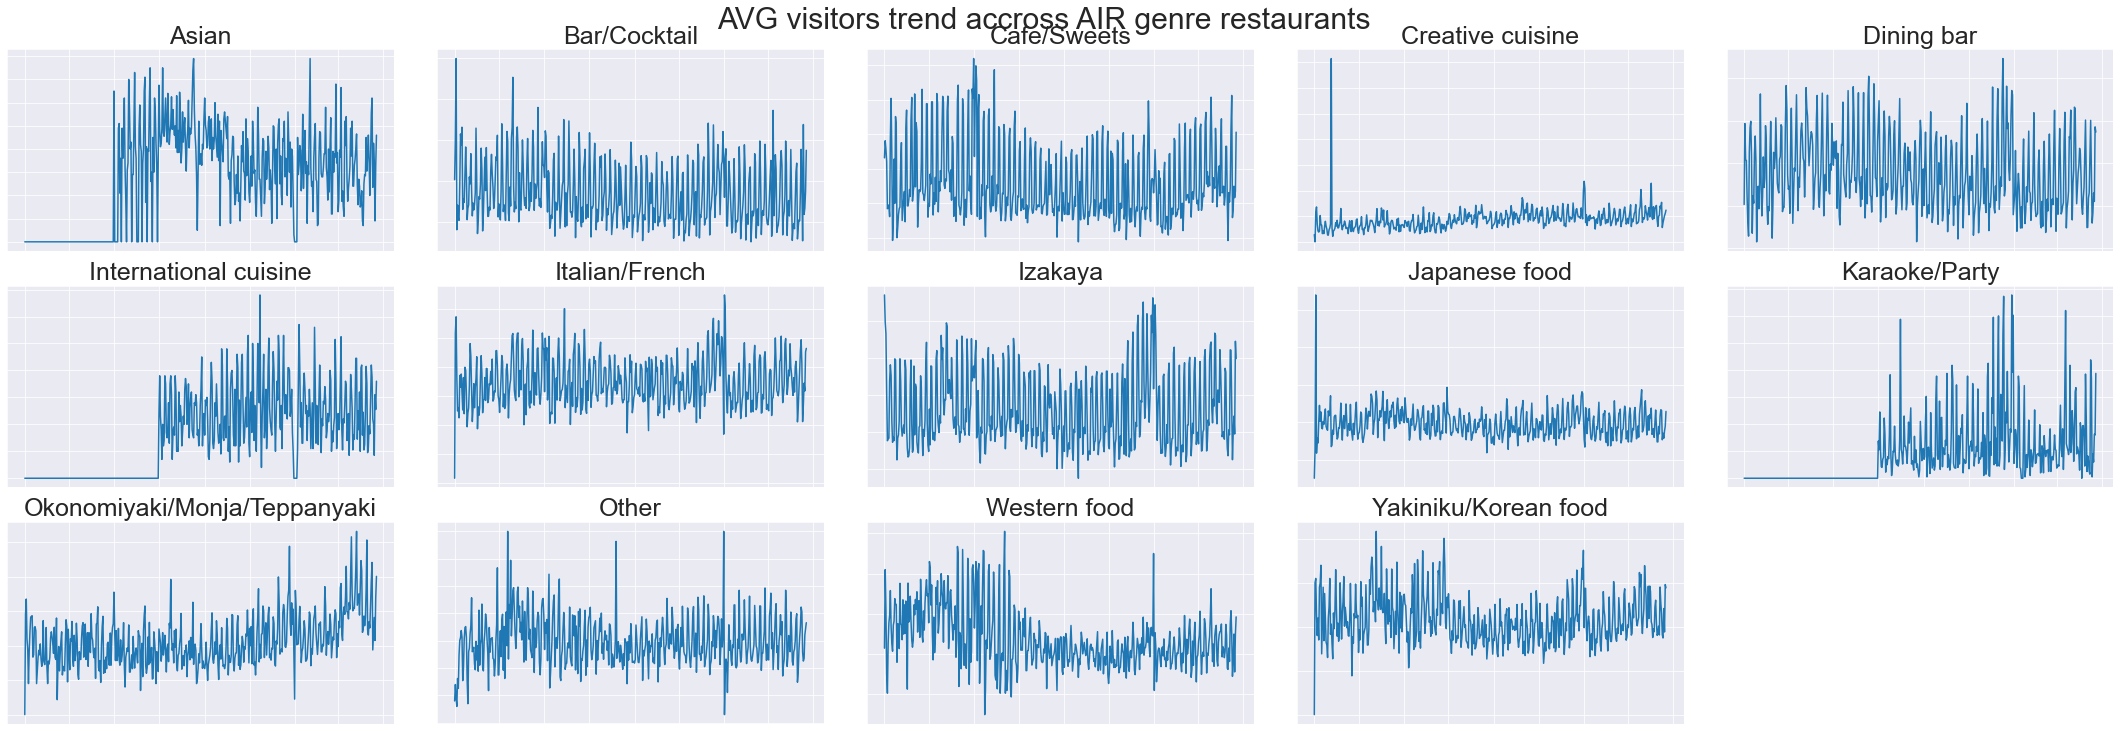

In [29]:
temp = train_data.groupby(["visit_date", 'air_genre_name']).visitors.mean()
temp = temp.unstack(-1, fill_value=0)

fig = plt.figure(figsize=(30,10))

columns = temp.columns
for index, genre in enumerate(columns):
    
    ax = fig.add_subplot(3,5, index+1)
    sns.lineplot(temp.index, temp[genre], ax=ax)
    ax.set_xticklabels(labels=[])
    ax.set_yticklabels(labels=[])
    ax.set_title(genre, fontsize=25)
    plt.xlabel("")
    plt.ylabel("")

fig.suptitle("AVG visitors trend accross AIR genre restaurants", fontsize=30, ha='center', va='baseline')
plt.tight_layout()
plt.show()
    

* `Most genre have consistent visitors. Some of them, 'Karoke/Party', 'International Cuisine' have no visits data upto certain date`
* `Korean Food, Western Food, Asian have variable visits`
* `Japanese food seems to have the most consistent visits`

#### Conclusion

* Visitors variable data is periodic in nature corresponding to a week pattern where there is a rise in visitors on weekends.
* The visit database has spike in data during July 2016, which might be the effect of additional restaurants being added to database.
* The Golden Week Season data can be seen in visitors variable, where the visitors have been consistent. This occurs during April 29 2016 to May 05 2016.
* We also see sharp dip in visitors on 2017-01-01. This might be due to most restaurants are closed on Jan 1st.
* On weekly basis, Visitors are high on Saturday and equally on Friday and Sunday.
* Month wise, December has more visitors compared to rest owing to festivals and New year's Eve.
* For obvious reasons, the visitors are high if its a public holiday.
* Restaurants see a rise in visitors if the next day is holiday, compared to next day working. This trend is also seen on weekly basis where Friday has more visitors compared to other working days, since Saturday is weekend.
* The reservations has similar trend to visitors. However, many prefer to walk in. This is evident from the huge difference between reservations and visitors.
* The AIR reservation system has missing data between 2016-07 to 2016-11. No explanation is given for this missing data.
* Both in AIR and HPG reservation system, the reservations are less before 2016-11, but there is sudden rise in reservations after this.
* Majority of the reservations are done for dinner time.
* Bars and snacks genre, also known as 'Izakaya' in Japan is most popular among customers. Also this is highly spread across locations.
* Next to Izakaya, Cafe/Sweets seems to be most popular. Most office workers are common at cafe for morning and after coffee.
* International Cusine/Asian/Karoke Party are least popular. Interestingly Party is least popular. Japanese is popular for its longest working hours, which might be one of the reasons.
* 'Fukuoka' is the most popular area for restaurants though it has marginally less restaurants than tokyo. However Tokyo has restaurants spread in clusters which in turn makes the visitors to be spread. Tokyo is the next popular area among consumers
* Osaka though contains second most restaurants, the visitors is marginally less compared to other two.
* 'Izakaya' is present in majority of locations followed by Cafe/sweets.
* Majority of genres have consistent customers, except western food, International Cuisine, Asian and Karaoke genres.

## 1.6 Feature Engineering
---

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_path = os.path.join(os.path.curdir, "Kaggle_Data")
processed_data_path = os.path.join(os.path.curdir, "Processed_Data")

In [ ]:
# read all the csv files

# air
air_visit_data = pd.read_csv(data_path + "/air_visit_data.csv")
air_visit_data.visit_date = pd.to_datetime(air_visit_data.visit_date)

air_reservation_data = pd.read_csv(data_path + "/air_reserve.csv")
air_store_info = pd.read_csv(data_path + "/air_store_info.csv")

# date info
date_info = pd.read_csv(data_path + "/date_info.csv")
date_info.calendar_date = pd.to_datetime(date_info.calendar_date)

# hpg
hpg_reservation_data = pd.read_csv(data_path + "/hpg_reserve.csv")
hpg_store_info = pd.read_csv(data_path + "/hpg_store_info.csv")
store_id_relation = pd.read_csv(data_path + "/store_id_relation.csv")

air_store_weather_info = pd.read_csv(processed_data_path + "/processed_air_store_weather_info.csv")

# submission
submission = pd.read_csv(data_path + "/sample_submission.csv")

In [ ]:
# process the submission file
submission['air_store_id'] = submission.id.apply(lambda x: "_".join(x.split("_")[:2]))
submission['visit_date'] = submission.id.apply(lambda x: x.split("_")[2])
submission.drop("id", axis=1, inplace=True)
submission = submission[['air_store_id', 'visit_date', 'visitors']]
submission.visit_date = pd.to_datetime(submission.visit_date)
submission.head()

In [59]:
# add true false tags to identify the training and submission data
air_visit_data['is_train'] = True
submission['is_train'] = False

In [50]:
# combine the train and test data into one
data = pd.concat([air_visit_data, submission])
data.head()

,air_store_id,visit_date,visitors,id
0,air_ba937bf13d40fb24,2016-01-13,25,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,NaN


In [51]:
# add store information to the data
data = pd.merge(data, air_store_info, how='left', on='air_store_id')
data.head(3)

,air_store_id,visit_date,visitors,id,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


#### Process outliers in visitors variable

* Some restaurants have visitors above 80. These are the events that occured during New year which doesn't represent the trend for the whole year, Especially the submission file contains the dates from May.
* replace these outliers with their max values of IQR

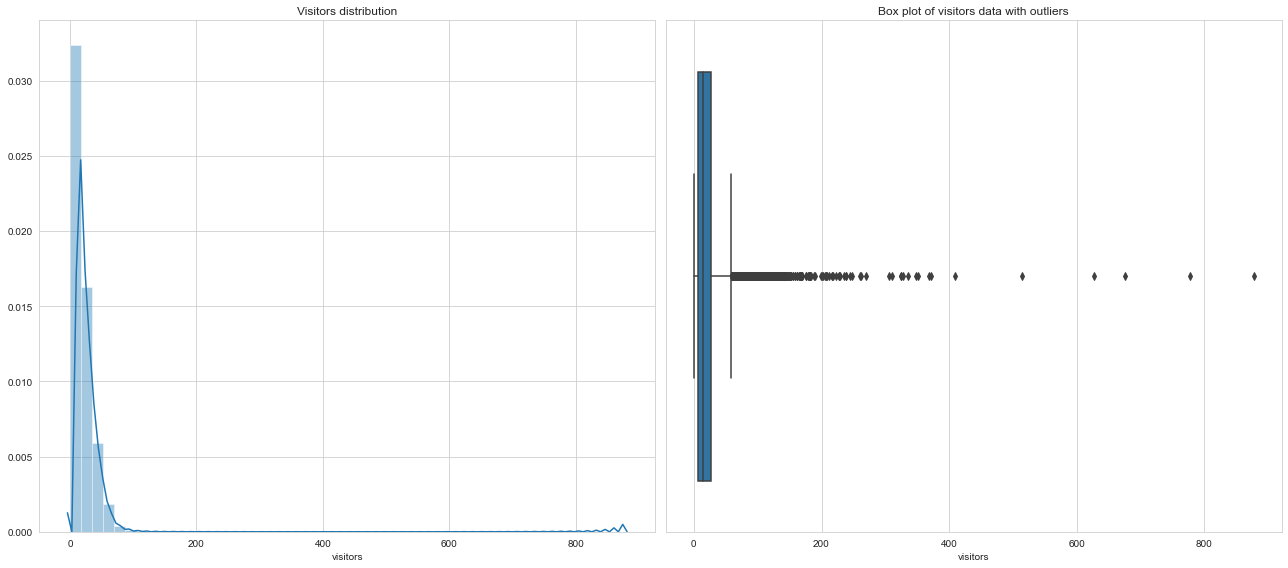

In [52]:
fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(121)

sns.distplot(data.visitors, ax=ax1)
plt.title("Visitors distribution")

ax2 = fig.add_subplot(122)

sns.boxplot(data.visitors, ax=ax2)
plt.title("Box plot of visitors data with outliers")

plt.tight_layout()
# plt.show()
plt.savefig("visitors_outliers", bbox_inches='tight')

In [63]:
def calulate_IQR_outlier_range(df):
    
    q1, q3 = np.quantile(df.values, [0.25, 0.75])
    lower_IQR = q1 - (1.5 * (q3 - q1))
    higher_IQR = q3 + (1.5 * (q3 - q1))
    
    return min(higher_IQR, df.max())

def replace_outliers(df, max_data):
    
    temp = pd.merge(df, max_data, how='left', on='air_store_id')
    
    return np.where(temp.visitors < temp.max_visitor, temp.visitors, temp.max_visitor)

In [64]:
stores = data[['air_store_id', 'visitors']].groupby('air_store_id')
max_store_vistors_capped = stores.apply(lambda x: calulate_IQR_outlier_range(x.visitors))
max_store_vistors_capped.name = 'max_visitor'
data['visitors_capped'] = replace_outliers(data[['air_store_id', 'visitors']], max_store_vistors_capped)

# add the log transformation of the visitors too
data['visitors_log1p'] = data.visitors.apply(lambda x: np.log1p(x))
data['visitors_capped_log1p'] = data.visitors_capped.apply(lambda x: np.log1p(x))

In [11]:
data.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p
0,air_ba937bf13d40fb24,2016-01-13,25,True,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,25.0,3.258097,3.258097
1,air_ba937bf13d40fb24,2016-01-14,32,True,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,32.0,3.496508,3.496508
2,air_ba937bf13d40fb24,2016-01-15,29,True,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,29.0,3.401197,3.401197


#### area wise restaurant count

* area wise restaurant count can be seen as a competition in the area

In [65]:
area_wise_store_count = air_store_info[['air_store_id', 'air_area_name']].groupby('air_area_name').count()
area_wise_store_count.rename(columns={'air_store_id': 'area_store_count'}, inplace=True)

#### area wise same genre restaurant count

* area wise same genre restaurant count can be seen as a competition in the area among same genre

In [66]:
area_wise_genre_count = air_store_info[['air_store_id', 'air_genre_name', 'air_area_name']].groupby(['air_area_name', 'air_genre_name']).count()
area_wise_genre_count.rename(columns={'air_store_id': 'area_genre_count'}, inplace=True)

In [67]:
# add the area competition and genre competition to the data
data = pd.merge(data, area_wise_store_count, how='left', on='air_area_name')
data = pd.merge(data, area_wise_genre_count, how='left', on=['air_area_name', 'air_genre_name'])
data.sort_values(['air_store_id', 'visit_date'], inplace=True)
data.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p,area_store_count,area_genre_count
87534,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,3.583519,20,4
87535,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,2.302585,20,4
87536,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,3.044522,20,4


#### Reserve visitors on the visit data

* visitors arriving on the visit date via reservation

In [68]:
# get the reservations done on HPG
hpg_reserve = pd.merge(store_id_relation, hpg_reservation_data, how='left', on='hpg_store_id')
hpg_reserve.drop("hpg_store_id", axis=1, inplace=True)

# concat both AIR and HPG reservations
reservation_data = pd.concat([air_reservation_data, hpg_reserve])

# add the hour gap diff between reseravtion time as a feature
reservation_data.visit_datetime = pd.to_datetime(reservation_data.visit_datetime)
reservation_data.reserve_datetime = pd.to_datetime(reservation_data.reserve_datetime)
reservation_data['reservation_gap'] = reservation_data.visit_datetime - reservation_data.reserve_datetime
reservation_data['reservation_gap'] = reservation_data.reservation_gap / np.timedelta64(1,'h')


# encode the visitors based on the reservation gap 
# 6th place solutuon features
# if reservation gap is under 12 hr
reservation_data['reserve_visitor_lt_12hr'] = np.where(reservation_data.reservation_gap < 12, reservation_data.reserve_visitors, 0)

# if reservation gap is between 12-36 hr
reservation_data['reserve_visitor_bt_12_36'] = np.where((reservation_data.reservation_gap >= 12) & (reservation_data.reservation_gap < 36), 
                                                        reservation_data.reserve_visitors, 0)

# if reservation gap is between 37-59 hr
reservation_data['reserve_visitor_bt_36_59'] = np.where((reservation_data.reservation_gap >= 36) & (reservation_data.reservation_gap < 59), 
                                                        reservation_data.reserve_visitors, 0)

# if reservation gap is between 59-85 hr
reservation_data['reserve_visitor_bt_59_85'] = np.where((reservation_data.reservation_gap >= 59) & (reservation_data.reservation_gap < 85), 
                                                        reservation_data.reserve_visitors, 0)

# if reservation gap is greater 85 hr
reservation_data['reserve_visitor_gt_85'] = np.where(reservation_data.reservation_gap >= 85, reservation_data.reserve_visitors, 0)
reservation_data['visit_date'] = reservation_data.visit_datetime.dt.date

# group by per store on visit date = reservation visitors
reservation_features = reservation_data.groupby(['air_store_id', 'visit_date'], as_index=False)[['reserve_visitors', 'reserve_visitor_lt_12hr', 
                                                                                                 'reserve_visitor_bt_12_36', 'reserve_visitor_bt_36_59',
                                                                                                'reserve_visitor_bt_59_85', 'reserve_visitor_gt_85']].sum()
# log transform the reservation featues
reservation_columns = reservation_features.columns[2:]
for column in reservation_columns:
    reservation_features[column] = reservation_features[column].apply(lambda a: np.log1p(a))

In [69]:
reservation_features.visit_date = pd.to_datetime(reservation_features.visit_date)
data = pd.merge(data, reservation_features, how='left', on=['air_store_id', 'visit_date']).fillna(0)

In [70]:
data.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,visitors_capped_log1p,area_store_count,area_genre_count,reserve_visitors,reserve_visitor_lt_12hr,reserve_visitor_bt_12_36,reserve_visitor_bt_36_59,reserve_visitor_bt_59_85,reserve_visitor_gt_85
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,3.583519,20,4,0.693147,0.0,0.693147,0.0,0.0,0.0
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,2.302585,20,4,0.000000,0.0,0.000000,0.0,0.0,0.0
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,3.044522,20,4,0.000000,0.0,0.000000,0.0,0.0,0.0


#### Holiday flag feature

* From the EDA, it is seen the visitors trend rises towards the holidays and vice versa

In [71]:
# non working is a day if it is a weekend, or a holiday marked by holiday flag
date_info['non_working'] = np.where(date_info.day_of_week.isin(['Saturday', 'Sunday']) | (date_info.holiday_flg == 1), 1, 0)
date_info['prev_day_holiday'] = date_info['non_working'].shift().fillna(0)
date_info['next_day_holiday'] = date_info['non_working'].shift(-1).fillna(0)
date_info.rename(columns={'calendar_date': 'visit_date'}, inplace=True)
data = pd.merge(data, date_info, how='left', on='visit_date')

In [72]:
data.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,...,reserve_visitor_lt_12hr,reserve_visitor_bt_12_36,reserve_visitor_bt_36_59,reserve_visitor_bt_59_85,reserve_visitor_gt_85,day_of_week,holiday_flg,non_working,prev_day_holiday,next_day_holiday
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,...,0.0,0.693147,0.0,0.0,0.0,Friday,0,0,0.0,1.0
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,...,0.0,0.000000,0.0,0.0,0.0,Saturday,0,1,0.0,1.0
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,...,0.0,0.000000,0.0,0.0,0.0,Monday,0,0,1.0,0.0


#### weather information
* weather information for the day can be useful

In [73]:
# read weather data
weather_data = os.path.join(data_path, "weather_data")
weather_station_data = os.path.join(weather_data, "1-1-16_5-31-17_Weather")

# check if processed file exists
if not os.path.isfile(processed_data_path + "/processed_air_store_weather_info.csv"):

    # prepare weather_data
    air_store_near_station = pd.read_csv(weather_data + "/air_store_info_with_nearest_active_station.csv")
    air_store_near_station = air_store_near_station.loc[:,['air_store_id', 'station_id']]
    air_store_near_station = air_store_near_station.set_index('air_store_id')

    # fetch weather data from each station for air_store
    air_store_weather_info = pd.DataFrame(columns=['calendar_date', 'avg_temperature',  
                                                        'low_temperature', 'high_temperature', 
                                                        'precipitation'])
    for index, row in air_store_near_station.iterrows():
        weather_file = os.path.join(weather_station_data, row.station_id + ".csv")
        temp_weather = pd.read_csv(weather_file).loc[:, ['calendar_date', 'avg_temperature',  
                                                        'low_temperature', 'high_temperature', 
                                                        'precipitation']]
        temp_weather.fillna(0, inplace=True)
        temp_weather['air_store_id'] = index

        air_store_weather_info = pd.concat([air_store_weather_info, temp_weather])

    # rearrage the columns
    air_store_weather_info = air_store_weather_info.loc[:,['air_store_id','calendar_date', 'avg_temperature',  
                                                        'low_temperature', 'high_temperature', 
                                                        'precipitation']].reset_index(drop=True)
    # save the processed file
    air_store_weather_info.to_csv(processed_data_path + "/processed_air_store_weather_info.csv", index=False)
else:

    air_store_weather_info = pd.read_csv(processed_data_path + "/processed_air_store_weather_info.csv")

In [74]:
air_store_weather_info.rename(columns={'calendar_date': 'visit_date'}, inplace=True)
air_store_weather_info.visit_date = pd.to_datetime(air_store_weather_info.visit_date)

data = pd.merge(data, air_store_weather_info, how='left', on=['air_store_id', 'visit_date'])

In [75]:
data.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,...,reserve_visitor_gt_85,day_of_week,holiday_flg,non_working,prev_day_holiday,next_day_holiday,avg_temperature,low_temperature,high_temperature,precipitation
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,...,0.0,Friday,0,0,0.0,1.0,25.6,22.0,30.6,0.0
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,...,0.0,Saturday,0,1,0.0,1.0,27.0,23.4,31.8,0.0
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,...,0.0,Monday,0,0,1.0,0.0,27.8,23.6,33.8,1.5


#### date features

In [76]:
data['visit_day'] = data.visit_date.dt.day
data['visit_month'] = data.visit_date.dt.month
data['visit_year'] = data.visit_date.dt.year
data['visit_week'] = data.visit_date.dt.weekofyear

#### Monthly visitors statistics

In [77]:
# calculating monthly visitors mean for each restaurants
month_wise_mean= data.groupby(['air_store_id','visit_month'],as_index=False)['visitors_capped'].mean()
month_wise_mean = month_wise_mean.pivot(index='air_store_id', columns='visit_month', values='visitors_capped').reset_index()
month_wise_mean.columns = ['air_store_id','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']

month_wise_mean_2= data.groupby(['air_store_id','visit_month'],as_index=False)['visitors_capped_log1p'].mean()
month_wise_mean_2 = month_wise_mean_2.pivot(index='air_store_id', columns='visit_month', values='visitors_capped_log1p').reset_index()
month_wise_mean_2.columns = ['air_store_id','m1_log1p','m2_log1p','m3_log1p','m4_log1p','m5_log1p','m6_log1p','m7_log1p','m8_log1p','m9_log1p',
                           'm10_log1p','m11_log1p','m12_log1p']


# merging with train & test data 
data = data.merge(month_wise_mean,on='air_store_id',how='left')
data = data.merge(month_wise_mean_2,on='air_store_id',how='left')

In [78]:
data.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,...,m3_log1p,m4_log1p,m5_log1p,m6_log1p,m7_log1p,m8_log1p,m9_log1p,m10_log1p,m11_log1p,m12_log1p
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,...,3.301495,2.233189,0.0,NaN,3.19615,3.117369,3.045224,3.009015,2.982401,3.230017
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,...,3.301495,2.233189,0.0,NaN,3.19615,3.117369,3.045224,3.009015,2.982401,3.230017
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,...,3.301495,2.233189,0.0,NaN,3.19615,3.117369,3.045224,3.009015,2.982401,3.230017


#### visitors statistics for stores by day of week, non_working

In [79]:
# storeId, nonworking
# average 
mean_visitor_working_1 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.mean()
mean_visitor_working_1.rename(columns={'visitors_capped': 'mean_visitors_cap_air_store_id_non_working'}, inplace=True)

# Median 
median_visitor_working_1 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.median()
median_visitor_working_1.rename(columns={'visitors_capped': 'median_visitors_cap_air_store_id_non_working'}, inplace=True)

# minimum
min_visitor_working_1 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.min()
min_visitor_working_1.rename(columns={'visitors_capped': 'min_visitors_cap_air_store_id_non_working'}, inplace=True)

# maximum
max_visitor_working_1 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.max()
max_visitor_working_1.rename(columns={'visitors_capped': 'max_visitors_cap_air_store_id_non_working'}, inplace=True)

# count
count_visitor_working_1 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped.count()
count_visitor_working_1.rename(columns={'visitors_capped': 'count_visitors_cap_air_store_id_non_working'}, inplace=True)

# std_visitor_working_1 = data.groupby(['air_store_id', 'non_working'], as_index=True).visitors_capped.std()
# std_visitor_working_1.name = 'std_visitors_cap_air_store_id_non_working'



# store_id, day_of_week
# average
mean_visitor_working_2 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.mean()
mean_visitor_working_2.rename(columns={'visitors_capped': 'mean_visitors_cap_air_store_id_dow'}, inplace=True)

# Median 
median_visitor_working_2 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.median()
median_visitor_working_2.rename(columns={'visitors_capped': 'median_visitors_cap_air_store_id_dow'}, inplace=True)

# minimum
min_visitor_working_2 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.min()
min_visitor_working_2.rename(columns={'visitors_capped': 'min_visitors_cap_air_store_id_dow'}, inplace=True)

# maximum
max_visitor_working_2 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.max()
max_visitor_working_2.rename(columns={'visitors_capped': 'max_visitors_cap_air_store_id_dow'}, inplace=True)

# count
count_visitor_working_2 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped.count()
count_visitor_working_2.rename(columns={'visitors_capped': 'count_visitors_cap_air_store_id_dow'}, inplace=True)

# std
# std_visitor_working_2 = data.groupby(['air_store_id', 'day_of_week'], as_index=True).visitors_capped.std()
# std_visitor_working_2.name = 'std_visitors_cap_air_store_id_dow'


# store_id
# average
mean_visitor_working_3 = data.groupby(['air_store_id'], as_index=False).visitors_capped.mean()
mean_visitor_working_3.rename(columns={'visitors_capped': 'mean_visitors_cap_air_store_id'}, inplace=True)

# Median 
median_visitor_working_3 = data.groupby(['air_store_id'], as_index=False).visitors_capped.median()
median_visitor_working_3.rename(columns={'visitors_capped': 'median_visitors_cap_air_store_id'}, inplace=True)

# minimum
min_visitor_working_3 = data.groupby(['air_store_id'], as_index=False).visitors_capped.min()
min_visitor_working_3.rename(columns={'visitors_capped': 'min_visitors_cap_air_store_id'}, inplace=True)

# maximum
max_visitor_working_3 = data.groupby(['air_store_id'], as_index=False).visitors_capped.max()
max_visitor_working_3.rename(columns={'visitors_capped': 'max_visitors_cap_air_store_id'}, inplace=True)

# count
count_visitor_working_3 = data.groupby(['air_store_id'], as_index=False).visitors_capped.count()
count_visitor_working_3.rename(columns={'visitors_capped': 'count_visitors_cap_air_store_id'}, inplace=True)

# std
# std_visitor_working_3 = data.groupby(['air_store_id'], as_index=True).visitors_capped.std()
# std_visitor_working_3.name = 'std_visitors_cap_air_store_id'


In [80]:
# storeId, nonworking
# average
mean_visitor_working_4 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.mean()
mean_visitor_working_4.rename(columns={'visitors_capped_log1p': 'mean_visitors_cap_log1p_air_store_id_non_working'}, inplace=True)

# Median 
median_visitor_working_4 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.median()
median_visitor_working_4.rename(columns={'visitors_capped_log1p': 'median_visitors_cap_log1p_air_store_id_non_working'}, inplace=True)

# minimum
min_visitor_working_4 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.min()
min_visitor_working_4.rename(columns={'visitors_capped_log1p': 'min_visitors_log1p_cap_air_store_id_non_working'}, inplace=True)

# maximum
max_visitor_working_4 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.max()
max_visitor_working_4.rename(columns={'visitors_capped_log1p': 'max_visitors_cap_log1p_air_store_id_non_working'}, inplace=True)

# count
count_visitor_working_4 = data.groupby(['air_store_id', 'non_working'], as_index=False).visitors_capped_log1p.count()
count_visitor_working_4.rename(columns={'visitors_capped_log1p': 'count_visitors_cap_log1p_air_store_id_non_working'}, inplace=True)

# std
# std_visitor_working_4 = data.groupby(['air_store_id', 'non_working'], as_index=True).visitors_capped_log1p.std()
# std_visitor_working_4.name = 'std_visitors_cap_log1p_air_store_id_non_working'


# store_id, day_of_week
# average
mean_visitor_working_5 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.mean()
mean_visitor_working_5.rename(columns={'visitors_capped_log1p': 'mean_visitors_cap_log1p_air_store_id_dow'}, inplace=True)

# Median
median_visitor_working_5 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.median()
median_visitor_working_5.rename(columns={'visitors_capped_log1p': 'median_visitors_cap_log1p_air_store_id_dow'}, inplace=True)

# minimum
min_visitor_working_5 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.min()
min_visitor_working_5.rename(columns={'visitors_capped_log1p': 'min_visitors_cap_log1p_air_store_id_dow'}, inplace=True)

# maximum
max_visitor_working_5 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.max()
max_visitor_working_5.rename(columns={'visitors_capped_log1p': 'max_visitors_cap_log1p_air_store_id_dow'}, inplace=True)

# count
count_visitor_working_5 = data.groupby(['air_store_id', 'day_of_week'], as_index=False).visitors_capped_log1p.count()
count_visitor_working_5.rename(columns={'visitors_capped_log1p': 'count_visitors_cap_log1p_air_store_id_dow'}, inplace=True)

# # std
# std_visitor_working_5 = data.groupby(['air_store_id', 'day_of_week'], as_index=True).visitors_capped_log1p.std()
# std_visitor_working_5.name = 'std_visitors_cap_log1p_air_store_id_dow'


# store_id
# average
mean_visitor_working_6 = data.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.mean()
mean_visitor_working_6.rename(columns={'visitors_capped_log1p': 'mean_visitors_cap_log1p_air_store_id'}, inplace=True)

# Median 
median_visitor_working_6 = data.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.median()
median_visitor_working_6.rename(columns={'visitors_capped_log1p': 'median_visitors_cap_log1p_air_store_id'}, inplace=True)

# minimum
min_visitor_working_6 = data.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.min()
min_visitor_working_6.rename(columns={'visitors_capped_log1p': 'min_visitors_cap_log1p_air_store_id'}, inplace=True)

# maximum
max_visitor_working_6 = data.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.max()
max_visitor_working_6.rename(columns={'visitors_capped_log1p': 'max_visitors_cap_log1p_air_store_id'}, inplace=True)

# count
count_visitor_working_6 = data.groupby(['air_store_id'], as_index=False).visitors_capped_log1p.count()
count_visitor_working_6.rename(columns={'visitors_capped_log1p': 'count_visitors_cap_log1p_air_store_id'}, inplace=True)

# # std
# std_visitor_working_6 = data.groupby(['air_store_id'], as_index=True).visitors_capped_log1p.std()
# std_visitor_working_6.name =  'std_visitors_cap_log1p_air_store_id'


In [81]:
data = pd.merge(data, mean_visitor_working_1, how='left', on=['air_store_id', 'non_working'])
data = pd.merge(data, median_visitor_working_1, how='left', on=['air_store_id', 'non_working'])
data = pd.merge(data, min_visitor_working_1, how='left', on=['air_store_id', 'non_working'])
data = pd.merge(data, max_visitor_working_1, how='left', on=['air_store_id', 'non_working'])
data = pd.merge(data, count_visitor_working_1, how='left', on=['air_store_id', 'non_working'])
# data = pd.merge(data, std_visitor_working_1, how='left', on=['air_store_id', 'non_working'])

data = pd.merge(data, mean_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])
data = pd.merge(data, median_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])
data = pd.merge(data, min_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])
data = pd.merge(data, max_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])
data = pd.merge(data, count_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])
# data = pd.merge(data, std_visitor_working_2, how='left', on=['air_store_id', 'day_of_week'])

data = pd.merge(data, mean_visitor_working_3, how='left', on=['air_store_id'])
data = pd.merge(data, median_visitor_working_3, how='left', on=['air_store_id'])
data = pd.merge(data, min_visitor_working_3, how='left', on=['air_store_id'])
data = pd.merge(data, max_visitor_working_3, how='left', on=['air_store_id'])
data = pd.merge(data, count_visitor_working_3, how='left', on=['air_store_id'])
# data = pd.merge(data, std_visitor_working_3, how='left', on=['air_store_id'])

data = pd.merge(data, mean_visitor_working_4, how='left', on=['air_store_id', 'non_working'])
data = pd.merge(data, median_visitor_working_4, how='left', on=['air_store_id', 'non_working'])
data = pd.merge(data, min_visitor_working_4, how='left', on=['air_store_id', 'non_working'])
data = pd.merge(data, max_visitor_working_4, how='left', on=['air_store_id', 'non_working'])
data = pd.merge(data, count_visitor_working_4, how='left', on=['air_store_id', 'non_working'])
# data = pd.merge(data, std_visitor_working_4, how='left', on=['air_store_id', 'non_working'])

data = pd.merge(data, mean_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])
data = pd.merge(data, median_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])
data = pd.merge(data, min_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])
data = pd.merge(data, max_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])
data = pd.merge(data, count_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])
# data = pd.merge(data, std_visitor_working_5, how='left', on=['air_store_id', 'day_of_week'])

data = pd.merge(data, mean_visitor_working_6, how='left', on=['air_store_id'])
data = pd.merge(data, median_visitor_working_6, how='left', on=['air_store_id'])
data = pd.merge(data, min_visitor_working_6, how='left', on=['air_store_id'])
data = pd.merge(data, max_visitor_working_6, how='left', on=['air_store_id'])
data = pd.merge(data, count_visitor_working_6, how='left', on=['air_store_id'])
# data = pd.merge(data, std_visitor_working_6, how='left', on=['air_store_id'])

#### Prefectures: Japan has 47 prefectures (hierarchy in area names)

In [82]:
data['area_prefecture'] = data.air_area_name.apply(lambda x: x.split()[0])
data['area_sub_prefecture'] = data.air_area_name.apply(lambda x: x.split()[1])

#### Nb. restaurants open on the visit week

In [83]:
total_restaurants = air_store_info.air_store_id.unique()
air_visit_data.visit_date = pd.to_datetime(air_visit_data.visit_date)
air_visit_data['visit_year'] = air_visit_data.visit_date.dt.year
air_visit_data['visit_month'] = air_visit_data.visit_date.dt.month
air_visit_data['visit_day'] = air_visit_data.visit_date.dt.day
air_visit_data['visit_week'] = air_visit_data.visit_date.dt.weekofyear
# 52 weeks in the 2016
air_visit_data.loc[air_visit_data.visit_week == 53, 'visit_week'] = 0
submission.visit_date = pd.to_datetime(submission.visit_date)
submission['visit_year'] = submission.visit_date.dt.year
submission['visit_month'] = submission.visit_date.dt.month
submission['visit_day'] = submission.visit_date.dt.day
submission['visit_week'] = submission.visit_date.dt.weekofyear
# 52 weeks in the 2016
submission.loc[submission.visit_week == 53, 'visit_week'] = 0
#submission.drop("id", axis=1, inplace=True)

total_data = pd.concat([air_visit_data, submission])

In [84]:
week_list = list(total_data['visit_week'].unique())
year_list = list(total_data['visit_year'].unique())

year_week_count = []
for year in year_list:
    for week_num in week_list:
    
        count = len(list(total_data.loc[(total_data.visit_year ==year) & (total_data.visit_week == week_num),'air_store_id'].unique()))
         # upto may 2017
        if (year == 2017) and (week_num>22):
            break
        
        year_week_count.append([year, week_num, count])
        
columns = ['visit_year', 'visit_week', 'open_resturant_count']
restaurant_weekly_open = pd.DataFrame(year_week_count, columns=columns)

data = pd.merge(data, restaurant_weekly_open, how='left', on=['visit_year', 'visit_week'])

In [85]:
data.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,...,max_visitors_cap_log1p_air_store_id_dow,count_visitors_cap_log1p_air_store_id_dow,mean_visitors_cap_log1p_air_store_id,median_visitors_cap_log1p_air_store_id,min_visitors_cap_log1p_air_store_id,max_visitors_cap_log1p_air_store_id,count_visitors_cap_log1p_air_store_id,area_prefecture,area_sub_prefecture,open_resturant_count
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,...,4.060443,45,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,...,4.170534,43,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,...,3.871201,41,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,794.0


#### Nb of reservations on the visit date

In [89]:

reservation_count_feature = reservation_data.groupby(['air_store_id', 'visit_date'], as_index=False).visit_datetime.count()
reservation_count_feature.visit_date = pd.to_datetime(reservation_count_feature.visit_date)
reservation_count_feature.rename(columns={'visit_datetime' : 'reservation_count'}, inplace=True)
data = pd.merge(data, reservation_count_feature, how='left', on=['air_store_id', 'visit_date']).fillna(0)
data.reservation_count = data.reservation_count.apply(lambda x: np.log1p(x))

In [90]:
data.head(3)

,air_store_id,visit_date,visitors,is_train,air_genre_name,air_area_name,latitude,longitude,visitors_capped,visitors_log1p,...,count_visitors_cap_log1p_air_store_id_dow,mean_visitors_cap_log1p_air_store_id,median_visitors_cap_log1p_air_store_id,min_visitors_cap_log1p_air_store_id,max_visitors_cap_log1p_air_store_id,count_visitors_cap_log1p_air_store_id,area_prefecture,area_sub_prefecture,open_resturant_count,reservation_count
0,air_00a91d42b08b08d9,2016-07-01,35,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,35.0,3.583519,...,45,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0,0.693147
1,air_00a91d42b08b08d9,2016-07-02,9,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,9.0,2.302585,...,43,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,787.0,0.000000
2,air_00a91d42b08b08d9,2016-07-04,20,True,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,20.0,3.044522,...,41,2.709983,3.178054,0.0,4.170534,271,Tōkyō-to,Chiyoda-ku,794.0,0.000000


In [91]:
# random features
data['lat+long'] = data.latitude + data.longitude
data['lat_max_diff'] = data.latitude.max() - data.latitude 
data['long_max_diff'] = data.longitude.max() - data.longitude 
# store the data
data.to_csv(processed_data_path + "/FE_DATA_V1.csv", index=False)

In [92]:
data.shape

(284127, 93)

### Feature Engineering - Summary:

1. **area wise restaurant count:**  *This features gives the total resturants in the restaurant area.*
2. **area wise same genre restaurant count:** *This feature gives the total same genre count in the restaurant area. This describes the peer competition in the area*
3. **reserve_visitors:** *This feature gives nb of visitors arriving to the restaurant through reservation*
4. **working:** *This feature describes if its a working day or holiday(holiday flg or weekend).*
5. **mean_visitors:**  *The average visitors expected for the restaurant on the day of week (working and Non-working)*
6. **median_visitors:**  *The median visitors expected for the restaurant on the day of week (working and Non-working)*
7. **min_visitors:**  *The minimum visitors expected for the restaurant on the day of week (working and Non-working)* 
8. **max_visitors:**  *The maximum visitors expected for the restaurant on the day of week (working and Non-working)*
9. **area wise expected visitors:** *This feature describes the nb of expected visitors share given total nb of resturants in the area*
10. **area wise genre expected visitors:** *This feature describes the nb of expected visitors share given total nb of resturants of the same genre in the area*
11. **area_prefecture**: *This are main Japan area_prefecture. Japan has 47 prefectures. "Fukuoka-ken Fukuoka-shi Momochi" where Fukuoka-ken is main prefecture*
12. **area sub prefecture:** *These are sub prefecture under main prefectures*
13. **monthly mean visitors:** *This feature descibes the mean visitors to the restaurant in time window of every month*
14. **monthly median visitors:** *This feature descibes the median visitors to the restaurant in time window of every month*
15. **monthly min visitors:** *This feature descibes the minimum visitors to the restaurant in time window of every month*
16. **monthly max visitors:** *This feature descibes the maximum visitors to the restaurant in time window of every month*
17. **average temperature**: *This feature describes the average temperature in the restaurant area from the nearest weather station*
18. **low temperature**: *This feature describes the lowest temperature in the restaurant area from the nearest weather station*
19. **high temperature**: *This feature describes the highest temperature in the restaurant area from the nearest weather station*
20. **precipitation:** *This feature descibes the possibility of rain in the restaurant area from the nearest weather station*

## 1.4 Modelling

1.4.1 prepare the data

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

processed_data_path = os.path.join(os.path.curdir, 'Processed_Data')

# read the processed data
data = pd.read_csv(processed_data_path + "/FE_DATA_V1.csv")
data.visit_date = pd.to_datetime(data.visit_date)
data.set_index('visit_date', inplace=True)

train = data.loc[data.is_train == True, :]
test = data.loc[data.is_train == False, :]

to_drop = ['air_store_id', 'is_train', 'visitors_capped', 'visitors_log1p', 'visitors', 'air_area_name']

In [3]:
# drop the unnecessary features
train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

import re
# fix the column names containing special characters
train = train.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', str(x)))
test = test.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', str(x)))

### Feature importances

In [148]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

dtr.fit(train.drop(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'],
                             axis=1).values, train['visitors_capped_log1p'].values.reshape(-1))

DecisionTreeRegressor()

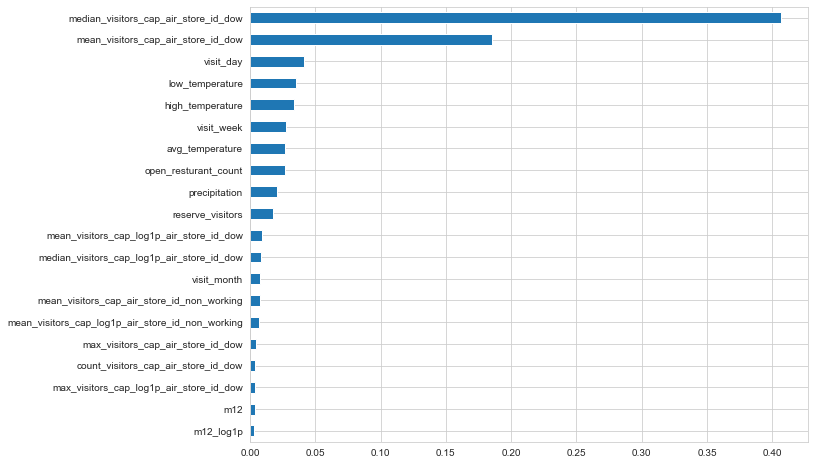

In [149]:
top_20 = pd.Series(dtr.feature_importances_, index = train.drop(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'],
                             axis=1).columns).nlargest(20)
top_20.sort_values().plot(kind='barh', figsize=(10, 8))

### Feature Selection by Recursive Feature Elimination

In [136]:
from sklearn.feature_selection import RFECV, RFE
import xgboost as xgb


model = xgb.XGBRegressor(objective='reg:squarederror',
                        eval_metric='rmse',
                        n_jobs=4)

# Instantiate RFECV visualizer with a XGBRegressor with step=5
rank_features = RFECV(model, step=10, scoring=rmsle_scorer, n_jobs=4, verbose=2)
rank_features.fit(train.drop(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'],
                             axis=1).values, train['visitors_capped_log1p'].values.reshape(-1))

Fitting estimator with 81 features.
Fitting estimator with 71 features.


RFECV(estimator=XGBRegressor(base_score=None, booster=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, eval_metric='rmse',
                             gamma=None, gpu_id=None, importance_type='gain',
                             interaction_constraints=None, learning_rate=None,
                             max_delta_step=None, max_depth=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=4, num_parallel_tree=None,
                             random_state=None, reg_alpha=None, reg_lambda=None,
                             scale_pos_weight=None, subsample=None,
                             tree_method=None, validate_parameters=None,
                             verbosity=None),
      n_jobs=4, scoring=make_scorer(rmsle, greater_is_better=False), step=10,
      verbose=2)

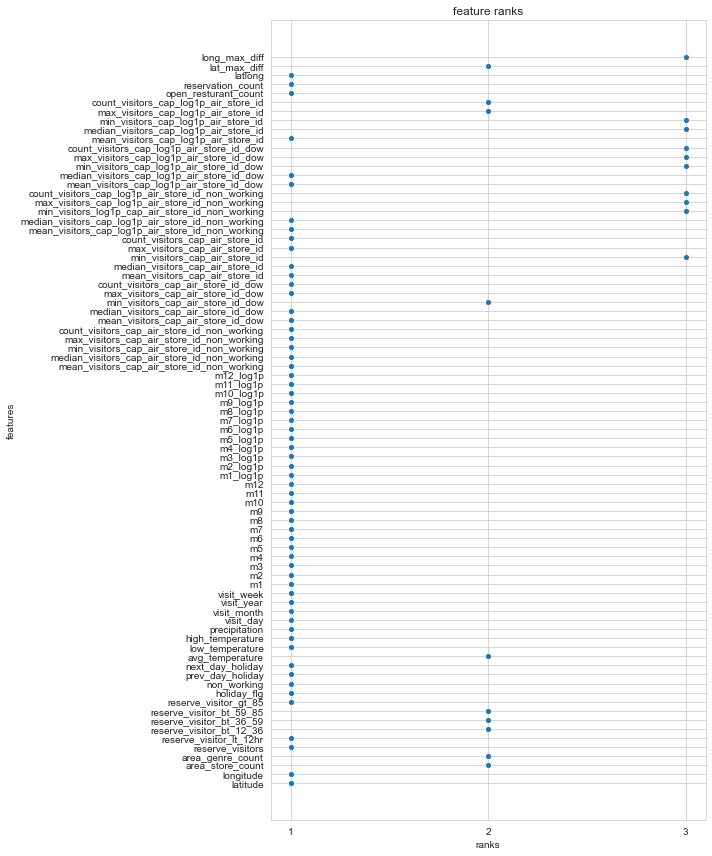

In [145]:

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)

sns.scatterplot(rank_features.ranking_, train.drop(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'], axis=1).columns, ax=ax)
plt.xticks(range(1,4))
plt.xlabel('ranks')
plt.ylabel("features")
plt.title("feature ranks")
plt.tight_layout()
plt.show()

In [147]:
# features with rank 1
selected_features = [feature for index, feature in enumerate(train.drop(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'],
                             axis=1).columns) if rank_features.support_[index]]
print("No of selected features: ", len(selected_features))

No of selected features:  61


In [ ]:
selected_features.extend(['visitors_capped_log1p', 'day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'])

x_train = train.loc[:, selected_features]
x_test = test.loc[:, selected_features]

x_train.to_csv(processed_data_path + "/feature_eliminated_train.csv", index=False)
x_test.to_csv(processed_data_path + "/feature_eliminated_test.csv", index=False)

In [5]:
x_train = pd.read_csv(processed_data_path + "/feature_eliminated_train.csv")
x_train.index = train.index
x_test = pd.read_csv(processed_data_path + "/feature_eliminated_test.csv")
x_test.index = test.index

In [8]:
x_train.shape, x_test.shape

((252108, 66), (32019, 66))

#### One hot code categorical features

In [6]:
x_train = pd.get_dummies(x_train, columns=['day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'])
x_test =  pd.get_dummies(x_test, columns=['day_of_week', 'area_prefecture', 'area_sub_prefecture', 'air_genre_name'])

In [7]:
print("No of features:", x_train.shape[1])
print("train data size: ", x_train.shape)
print("test data size: ", x_test.shape)

No of features: 147
train data size:  (252108, 147)
test data size:  (32019, 147)


### train/validation split

In [8]:
# training : 2016-01-01 to 2017-03-31 = 15 months
x_tr = x_train.loc[x_train.index <= pd.to_datetime('2017-03-31', format="%Y-%m-%d")].copy()
y_tr = x_train.loc[x_train.index <= pd.to_datetime('2017-03-31', format="%Y-%m-%d")]['visitors_capped_log1p'].copy()

# validation : 2017-04-01 - 2017-04-22 : April train data
x_val = x_train.loc[x_train.index > pd.to_datetime('2017-03-31', format="%Y-%m-%d")].copy()
y_val = x_train.loc[x_train.index > pd.to_datetime('2017-03-31', format="%Y-%m-%d")]['visitors_capped_log1p'].copy()
x_tr.drop('visitors_capped_log1p', axis=1, inplace=True)
x_val.drop('visitors_capped_log1p', axis=1, inplace=True)

# test : 2017-04-23 - 2017-05-30
x_test = x_test.drop('visitors_capped_log1p', axis=1)

print("train: ", x_tr.shape)
print("validation: ", x_val.shape)
print("test: ", x_test.shape)

train:  (236338, 146)
validation:  (15770, 146)
test:  (32019, 146)


#### score function

In [9]:
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):
    """
    This function will calculate the RMSLE score given the predicition and true values
    """

    # get exp of log predictions
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)

    # calculate the rmsle
    # formula 
    return np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))

rmsle_scorer = make_scorer(score_func=rmsle, greater_is_better=False)

### training with selected features

In [10]:
from sklearn.preprocessing import StandardScaler

# scaled
std = StandardScaler() 
x_tr_std = std.fit_transform(x_tr)
x_val_std = std.fit_transform(x_val)

std.fit(np.r_[x_tr.values, x_val.values])
x_test_std = std.transform(x_test)

### model1 : KNNRegression

**Hyper-parameter:** 
* *No of neighbours tuning*

In [155]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# hyper parameter tuning
param = dict(n_neighbors=[ i for i in range(1, 20, 2)])


knnr = KNeighborsRegressor(n_jobs = -1)


grid_search = GridSearchCV(estimator=knnr,
                      param_grid=param,
                      n_jobs= -1,
                      cv=4,
                      scoring=rmsle_scorer,
                      verbose=10,
                      return_train_score=True)

In [156]:
grid_search.fit(x_tr.values, y_tr.values.reshape(-1))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 25.3min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 30.5min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 32.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 32.4min finished


GridSearchCV(cv=4, estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=10)

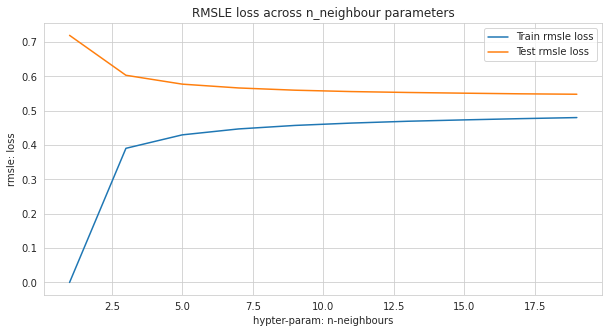

In [157]:
knn_cv_results = pd.DataFrame(grid_search.cv_results_)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
sns.lineplot(x=knn_cv_results.param_n_neighbors, y=knn_cv_results.mean_train_score * -1, label="Train rmsle loss", ax=ax)
sns.lineplot(x=knn_cv_results.param_n_neighbors, y=knn_cv_results.mean_test_score * -1, label="Test rmsle loss", ax=ax)
plt.xlabel("hypter-param: n-neighbours")
plt.ylabel("rmsle: loss")
plt.title("RMSLE loss across n_neighbour parameters")
plt.show()

#### training KNN with best regressor

In [158]:
# best knn estimator
knnr = grid_search.best_estimator_

knnr.fit(x_tr.values, y_tr.values.reshape(-1))

KNeighborsRegressor(n_jobs=-1, n_neighbors=19)

In [159]:
knn_val_predictions = knnr.predict(x_val.values)

print("RMSLE score: KNN-regression: ", rmsle(y_val.values, knn_val_predictions))

RMSLE score: KNN-regression:  0.51938533731797


#### KNN-regression: submission data

In [160]:
# best knn estimator
knnr = grid_search.best_estimator_
knn_train = np.r_[x_tr.values, x_val.values]
knn_y = np.r_[y_tr.values, y_val.values]

knnr.fit(knn_train, knn_y)

KNeighborsRegressor(n_jobs=-1, n_neighbors=19)

In [24]:
## holiday trick on the submission data
## https://www.kaggle.com/h4211819/holiday-trick
## This trick is done to clear the exception of the golden week in the submission file
## The golden week spans from April 29 2017(Saturday) to May 5 2017(Friday) = 7 days
## Of 7, May 2 and 3 are working days and rest are holiday
## From EDA we know that the weekends or holidays has more visitors compared to working days
## So the trick is to treat the holidays as weekend(saturday) and the two working days as Friday

def holiday_trick(submission):
    
    sub = submission.copy()
    sub['date'] = pd.to_datetime(sub.id.str[21:])
    sub['golden_week_visitors'] = np.nan
    # geometric mean
    sub.loc[sub.date == '2017-05-03', 'golden_week_visitors'] = np.sqrt(np.abs(sub.loc[sub.date=='2017-4-29','visitors'].values * sub.loc[sub.date=='2017-5-13','visitors'].values))
    sub.loc[sub.date == '2017-05-04', 'golden_week_visitors'] = np.sqrt(np.abs(sub.loc[sub.date=='2017-4-29','visitors'].values * sub.loc[sub.date=='2017-5-13','visitors'].values))
    sub.loc[sub.date == '2017-05-05', 'golden_week_visitors'] = np.sqrt(np.abs(sub.loc[sub.date=='2017-4-29','visitors'].values * sub.loc[sub.date=='2017-5-13','visitors'].values))
    sub.loc[sub.date == '2017-05-02', 'golden_week_visitors'] = np.sqrt(np.abs(sub.loc[sub.date=='2017-4-28','visitors'].values * sub.loc[sub.date=='2017-5-12','visitors'].values))
    
    # replace the predicted visitors
    sub.loc[sub.date == '2017-05-03', 'visitors'] = sub.loc[sub.date == '2017-05-03', 'golden_week_visitors']
    sub.loc[sub.date == '2017-05-04', 'visitors'] = sub.loc[sub.date == '2017-05-04', 'golden_week_visitors']
    sub.loc[sub.date == '2017-05-05', 'visitors'] = sub.loc[sub.date == '2017-05-05', 'golden_week_visitors']
    sub.loc[sub.date == '2017-05-02', 'visitors'] = sub.loc[sub.date == '2017-05-02', 'golden_week_visitors']
    
    return sub[['id', 'visitors']]

In [162]:
knn_test_predictions = knnr.predict(x_test)

sample_submission = pd.read_csv(data_path + "/sample_submission.csv")
sample_submission.visitors = np.expm1(knn_test_predictions)


In [163]:
# save the knn results
sample_submission.to_csv(results_path + "/knnr_sample_submission.csv", float_format='%.5f', index=False)

# save the subission with hoilday trick results
sample_submission_2 = holiday_trick(sample_submission)
sample_submission_2.to_csv(results_path + f"/knnr_sample_submission_{rmsle(y_val.values, knn_val_predictions):.5f}_ht.csv", float_format='%.5f', index=False)

knn_cv_results.to_csv(results_path + "/knn_cv_results.csv", index=False)

with open(results_path + f"/knn_regression_{rmsle(y_val.values, knn_val_predictions):.5f}.pickle", 'wb') as f:
    pickle.dump(knnr, f)

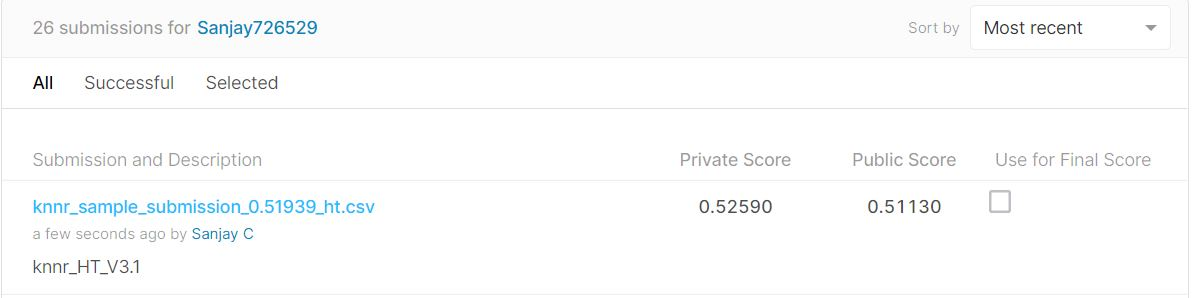

---
## Model 2: Linear regression(SGD)

**Hyperparameters:**
* *alpha: l2 penalty value*

In [164]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# hyperparameters
sgd_param = dict(alpha=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10])
# estimator
sgd = SGDRegressor()

# hyperparameters search
sgd_grid_search = GridSearchCV(estimator=sgd,
                      param_grid=sgd_param,
                      n_jobs= 3,
                      cv= 4,
                      scoring=rmsle_scorer,
                      verbose=10,
                      return_train_score=True)

In [165]:
sgd_grid_search.fit(x_tr_std, y_tr.values.reshape(-1))

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    8.0s
[Parallel(n_jobs=3)]: Done  26 out of  28 | elapsed:   10.2s remaining:    0.8s
[Parallel(n_jobs=3)]: Done  28 out of  28 | elapsed:   11.1s finished


GridSearchCV(cv=4, estimator=SGDRegressor(), n_jobs=3,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=10)

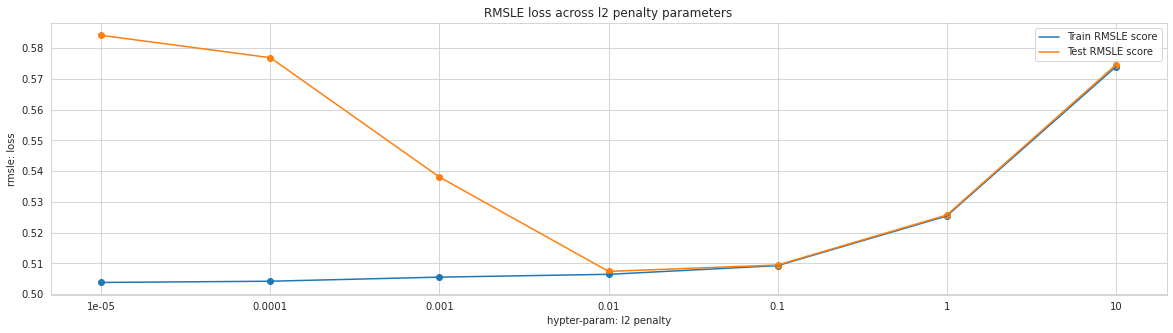

In [166]:
lr_cv_results = pd.DataFrame(sgd_grid_search.cv_results_)
lr_cv_results

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
alpha = lr_cv_results.param_alpha.values
plt.plot(range(len(alpha)), lr_cv_results.mean_train_score * -1, label='Train RMSLE score')
plt.plot(range(len(alpha)), lr_cv_results.mean_test_score * -1, label='Test RMSLE score')
plt.scatter(range(len(alpha)), lr_cv_results.mean_train_score * -1)
plt.scatter(range(len(alpha)), lr_cv_results.mean_test_score * -1)
plt.xticks(range(len(alpha)), list(alpha))
plt.legend()
plt.xlabel("hypter-param: l2 penalty")
plt.ylabel("rmsle: loss")
plt.title("RMSLE loss across l2 penalty parameters")
plt.show()

#### training LR with best regressor

In [167]:
# best knn estimator
sgd_lr = sgd_grid_search.best_estimator_

sgd_lr.fit(x_tr_std, y_tr.values)

SGDRegressor(alpha=0.01)

In [168]:
sgd_val_predictions = sgd_lr.predict(x_val_std)

print("RMSLE score: LR-regression: ", rmsle(y_val.values, sgd_val_predictions))

RMSLE score: LR-regression:  0.5127676179506069


#### LR-regression: submission data

In [169]:
# best knn estimator
sgd_lr = sgd_grid_search.best_estimator_

sgd_lr.fit(np.r_[x_tr_std, x_val_std], np.r_[y_tr.values, y_val.values])

SGDRegressor(alpha=0.01)

In [170]:
LR_test_predictions = sgd_lr.predict(x_test_std)

sample_submission = pd.read_csv(data_path + "/sample_submission.csv")
sample_submission.visitors = np.expm1(LR_test_predictions)


In [171]:
# save the LR results
sample_submission.to_csv(results_path + f"/SGDLR_sample_submission_{rmsle(y_val.values, sgd_val_predictions):.5f}.csv", float_format='%.5f', index=False)

sample_submission_2 = holiday_trick(sample_submission)
sample_submission_2.to_csv(results_path + f"/SGDLR_sample_submission_{rmsle(y_val.values, sgd_val_predictions):.5f}_ht.csv", float_format='%.5f', index=False)

lr_cv_results.to_csv(results_path + f"/SGDLR_cv_results_{rmsle(y_val.values, sgd_val_predictions):.5f}.csv", index=False)

with open(results_path + f"/SGDLR_regression_{rmsle(y_val.values, sgd_val_predictions):.5f}.pickle", 'wb') as f:
    pickle.dump(sgd_lr, f)

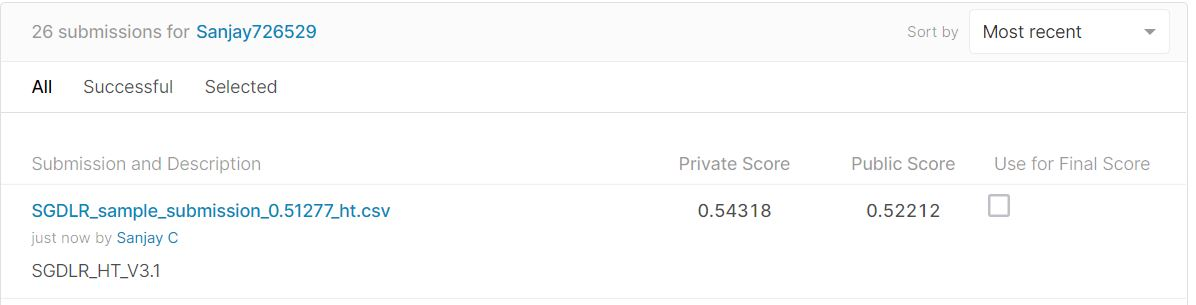

---
## Model 3: Tree models: Decision Tree Regressor

**HyperParameters**
* *max_depth*
* *min_samples_split*
* *min_samples_leaf*


In [172]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

# hyper parameters
dt_param = dict(max_depth = [1, 5, 10, 50],
              min_samples_split = [5, 10, 100, 500],
                 min_samples_leaf= [5, 10, 50])

# grid search
dt_grid_search = GridSearchCV(estimator=dt,
                      param_grid=dt_param,
                      scoring=rmsle_scorer,
                      n_jobs=-1,
                      cv=3,
                      verbose=10,
                      return_train_score=True)


In [173]:
dt_grid_search.fit(x_tr, y_tr)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.2min finished


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_leaf': [5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=10)

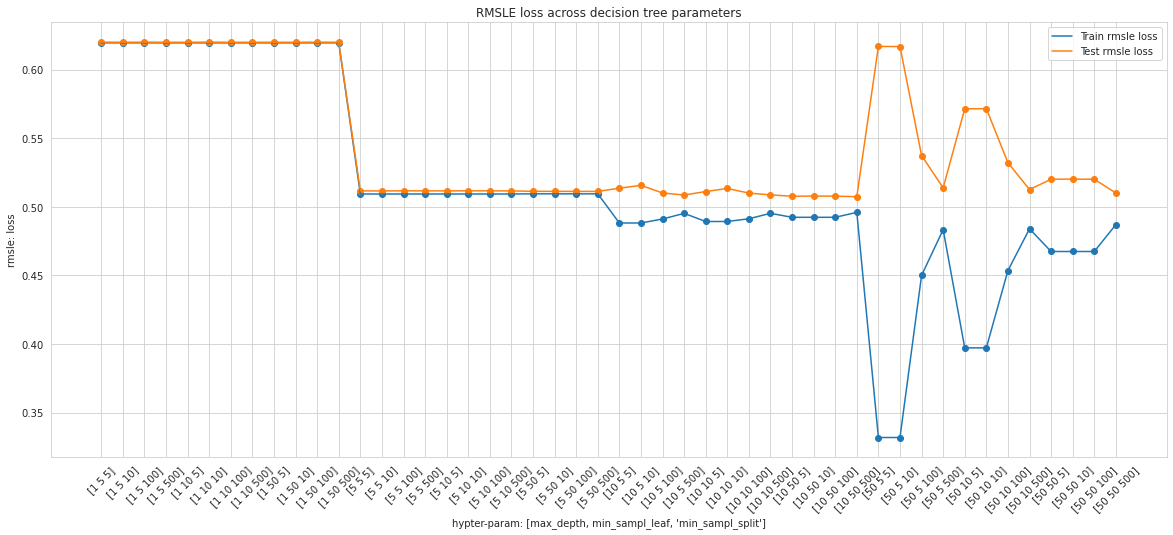

In [174]:
if os.path.isfile(results_path + "/DT_cv_results.csv"):
    dt_cv_results = pd.read_csv(results_path + "/DT_cv_results.csv")
else:
    dt_cv_results = pd.DataFrame(dt_grid_search.cv_results_)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

mean_train_score = dt_cv_results.mean_train_score.values
mean_test_score = dt_cv_results.mean_test_score
params = [ str(row.values) for index, row in dt_cv_results[['param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split']].iterrows()]

plt.plot(range(len(params)), dt_cv_results.mean_train_score * -1, 
             label="Train rmsle loss")
plt.plot(range(len(params)), dt_cv_results.mean_test_score * -1, 
             label="Test rmsle loss")
plt.scatter(range(len(params)), dt_cv_results.mean_train_score * -1)
plt.scatter(range(len(params)), dt_cv_results.mean_test_score * -1)
plt.xticks(range(len(params)), labels = params, rotation=45)
plt.legend()
plt.xlabel("hypter-param: [max_depth, min_sampl_leaf, 'min_sampl_split']")
plt.ylabel("rmsle: loss")
plt.title("RMSLE loss across decision tree parameters")
plt.show()

#### training DT with best parameters

In [175]:
# best knn estimator
dt = dt_grid_search.best_estimator_

dt.fit(x_tr, y_tr.values.reshape(-1))

DecisionTreeRegressor(max_depth=10, min_samples_leaf=50, min_samples_split=500)

In [176]:
dt_val_predictions = dt.predict(x_val)

print("RMSLE score: DT-regression: ", rmsle(y_val.values, dt_val_predictions))

RMSLE score: DT-regression:  0.5047152014000827


#### Decision Tree: Submission data

In [177]:
# best knn estimator
dt = dt_grid_search.best_estimator_

dt.fit(np.r_[x_tr.values, x_val.values], np.r_[y_tr.values, y_val.values])

DecisionTreeRegressor(max_depth=10, min_samples_leaf=50, min_samples_split=500)

In [178]:
DT_test_predictions = dt.predict(x_test)

sample_submission = pd.read_csv(data_path + "/sample_submission.csv")
sample_submission.visitors = np.expm1(DT_test_predictions)

In [179]:
# save the DT results
sample_submission.to_csv(results_path + f"/DT_sample_submission_{rmsle(y_val.values, dt_val_predictions):.5f}.csv", index=False)

sample_submission_2 = holiday_trick(sample_submission)
sample_submission_2.to_csv(results_path + f"/DT_sample_submission_{rmsle(y_val.values, dt_val_predictions):.5f}_ht.csv", float_format='%.5f', index=False)

dt_cv_results.to_csv(results_path + f"/DT_cv_results_{rmsle(y_val.values, dt_val_predictions):.5f}.csv", index=False)

with open(results_path + f"/DT_regression_{rmsle(y_val.values, dt_val_predictions):.5f}.pickle", 'wb') as f:
    pickle.dump(dt, f)

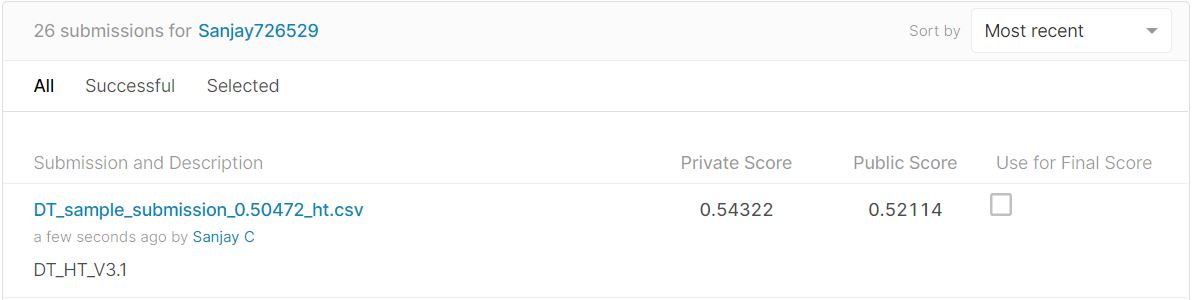

---
## Model 4: Random Forest

**hyperparameters**
* *max_depth*
* *n_estimators*

In [185]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()


# grid parameters
rf_params = dict(n_estimators = [5, 10, 50, 100, 250, 500],
                max_depth = [1, 5, 10, 50, 100])
              
# search for best params
rf_rand_cv = RandomizedSearchCV(estimator=rf,
                     param_distributions=rf_params,
                     cv=3,
                     scoring=rmsle_scorer,
                    verbose=10,
                     return_train_score=True,
                     n_jobs=-1)

In [186]:
rf_rand_cv.fit(x_tr.values, y_tr.values.reshape(-1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  6.1min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  7.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 17.0min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 26.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 5, 10, 50, 100],
                                        'n_estimators': [5, 10, 50, 100, 250,
                                                         500]},
                   return_train_score=True,
                   scoring=make_scorer(rmsle, greater_is_better=False),
                   verbose=10)

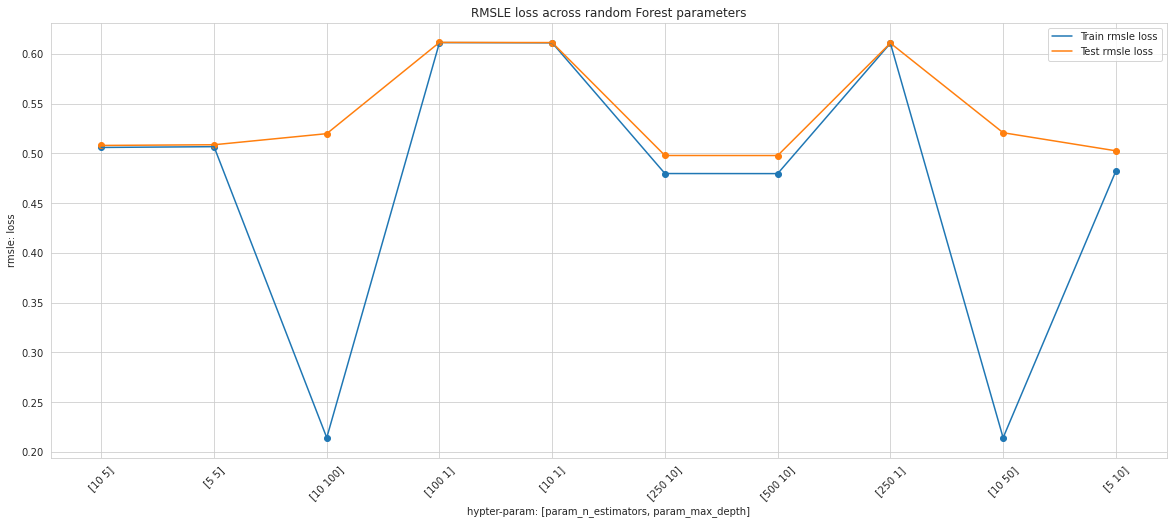

In [190]:
if os.path.isfile(results_path + "/RF_cv_results.csv"):
    rf_cv_results = pd.read_csv(results_path + "/RF_cv_results.csv")
else:
    rf_cv_results = pd.DataFrame(rf_rand_cv.cv_results_)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

mean_train_score = rf_cv_results.mean_train_score.values
mean_test_score = rf_cv_results.mean_test_score
params = [ str(row.values) for index, row in rf_cv_results[['param_n_estimators', 'param_max_depth']].iterrows()]

plt.plot(range(len(params)), rf_cv_results.mean_train_score * -1, 
             label="Train rmsle loss")
plt.plot(range(len(params)), rf_cv_results.mean_test_score * -1, 
             label="Test rmsle loss")
plt.scatter(range(len(params)), rf_cv_results.mean_train_score * -1)
plt.scatter(range(len(params)), rf_cv_results.mean_test_score * -1)
plt.xticks(range(len(params)), labels = params, rotation=45)
plt.legend()
plt.xlabel("hypter-param: [param_n_estimators, param_max_depth]")
plt.ylabel("rmsle: loss")
plt.title("RMSLE loss across random Forest parameters")
plt.show()

#### training RF with best parameters

In [188]:
# best rf estimator
rf = rf_rand_cv.best_estimator_

rf.fit(x_tr.values, y_tr.values.reshape(-1))

RandomForestRegressor(max_depth=10, n_estimators=500)

In [189]:
rf_val_predictions = rf.predict(x_val)

print("RMSLE score: RF-regression: ", rmsle(y_val.values, rf_val_predictions))

RMSLE score: RF-regression:  0.5003511049617472


#### Random Forest: Submission data

In [191]:
# best rf estimator
rf = rf_rand_cv.best_estimator_

rf.fit(np.r_[x_tr.values, x_val.values], np.r_[y_tr.values, y_val.values])

RandomForestRegressor(max_depth=10, n_estimators=500)

In [193]:
RF_test_predictions = rf.predict(x_test)

sample_submission = pd.read_csv(data_path + "/sample_submission.csv")
sample_submission.visitors = np.expm1(RF_test_predictions)

In [194]:
# save the RF results
sample_submission.to_csv(results_path + f"/RF_sample_submission_{rmsle(y_val.values, rf_val_predictions):.5f}.csv", index=False)

sample_submission_2 = holiday_trick(sample_submission)
sample_submission_2.to_csv(results_path + f"/RF_sample_submission_{rmsle(y_val.values, rf_val_predictions):.5f}_ht.csv", float_format='%.5f', index=False)

rf_cv_results.to_csv(results_path + f"/RF_cv_results_{rmsle(y_val.values, rf_val_predictions):.5f}.csv", index=False)

with open(results_path + f"/RF_regression_{rmsle(y_val.values, rf_val_predictions):.5f}.pickle", 'wb') as f:
    pickle.dump(rf, f)

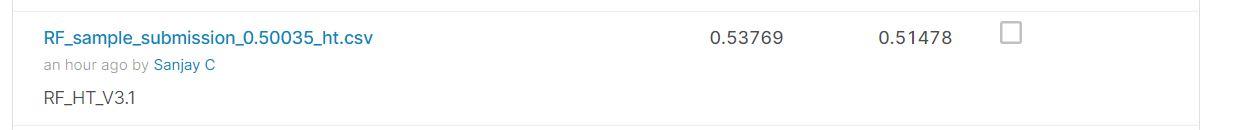

---
## Model 5: XGBoost

**hyperparameters**
* *max_depth*
* *learning_rate*
* *n_estimators*

In [198]:
from xgboost import XGBRegressor


# hyperparameters
xgbm_params = dict(learning_rate = [0.001, 0.003, 0.01, 0.1],
                   colsample_bytree = [0.3, 0.4, 0.5],
                    min_child_weight = [0.7, 0.8, 0.9, 1],
                    max_depth = [2, 4, 8],
                    subsample = [0.5, 0.6, 0.7])

# xg boost model
xgbmr = XGBRegressor(n_jobs=4)

# cross validation
xgbmr_rand_search = RandomizedSearchCV(estimator=xgbmr,
                     param_distributions=xgbm_params,
                     cv=3,
                     return_train_score=True,
                     n_jobs=-1,
                     verbose=1-0,
                     scoring=rmsle_scorer)

In [199]:
xgbmr_rand_search.fit(x_tr.values, y_tr.values.reshape(-1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.1min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [200]:
xgbmr_cv_results = pd.DataFrame(xgbmr_rand_search.cv_results_)

#### training xgboost with best parameters

In [13]:
import xgboost as xgb
# best parameters
xgbm_best_params = {'objective':'reg:squarederror', # objective for regression
              'eval_metric':'rmse', # root mean squared error
              'learning_rate':0.01, 
              'min_child_weight':0.8,
              'subsample':0.7,
              'colsample_bytree':0.5,
              'max_depth': 8}

# xgb.DMatrix
x_train_matrix = xgb.DMatrix(data=x_tr, label=y_tr)
x_val_matrix = xgb.DMatrix(data=x_val, label=y_val)

# training model
model = xgb.train(params=xgbm_best_params,
                 dtrain=x_train_matrix,
                 evals=[(x_train_matrix, 'train'), (x_val_matrix, 'test')],
                early_stopping_rounds=100, 
                 num_boost_round=5000)

[0]	train-rmse:2.41073	test-rmse:2.42233
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[1]	train-rmse:2.38771	test-rmse:2.39908
[2]	train-rmse:2.36491	test-rmse:2.37614
[3]	train-rmse:2.34238	test-rmse:2.35353
[4]	train-rmse:2.32004	test-rmse:2.33106
[5]	train-rmse:2.29796	test-rmse:2.30884
[6]	train-rmse:2.27608	test-rmse:2.28688
[7]	train-rmse:2.25446	test-rmse:2.26511
[8]	train-rmse:2.23304	test-rmse:2.24352
[9]	train-rmse:2.21184	test-rmse:2.22224
[10]	train-rmse:2.19089	test-rmse:2.20111
[11]	train-rmse:2.17015	test-rmse:2.18024
[12]	train-rmse:2.14962	test-rmse:2.15957
[13]	train-rmse:2.12932	test-rmse:2.13918
[14]	train-rmse:2.10922	test-rmse:2.11896
[15]	train-rmse:2.08936	test-rmse:2.09901
[16]	train-rmse:2.06968	test-rmse:2.07926
[17]	train-rmse:2.05021	test-rmse:2.05959
[18]	train-rmse:2.03095	test-rmse:2.04016
[19]	train-rmse:2.01188	test-rmse:2.02093
[20]	train-rmse:1.99302	te

[190]	train-rmse:0.59976	test-rmse:0.60381
[191]	train-rmse:0.59764	test-rmse:0.60185
[192]	train-rmse:0.59561	test-rmse:0.59986
[193]	train-rmse:0.59357	test-rmse:0.59792
[194]	train-rmse:0.59156	test-rmse:0.59596
[195]	train-rmse:0.58959	test-rmse:0.59407
[196]	train-rmse:0.58763	test-rmse:0.59210
[197]	train-rmse:0.58573	test-rmse:0.59035
[198]	train-rmse:0.58385	test-rmse:0.58858
[199]	train-rmse:0.58199	test-rmse:0.58665
[200]	train-rmse:0.58017	test-rmse:0.58492
[201]	train-rmse:0.57837	test-rmse:0.58323
[202]	train-rmse:0.57659	test-rmse:0.58156
[203]	train-rmse:0.57485	test-rmse:0.57984
[204]	train-rmse:0.57315	test-rmse:0.57821
[205]	train-rmse:0.57148	test-rmse:0.57654
[206]	train-rmse:0.56984	test-rmse:0.57494
[207]	train-rmse:0.56822	test-rmse:0.57341
[208]	train-rmse:0.56660	test-rmse:0.57179
[209]	train-rmse:0.56504	test-rmse:0.57030
[210]	train-rmse:0.56349	test-rmse:0.56885
[211]	train-rmse:0.56197	test-rmse:0.56743
[212]	train-rmse:0.56047	test-rmse:0.56590
[213]	train

[381]	train-rmse:0.47461	test-rmse:0.49385
[382]	train-rmse:0.47447	test-rmse:0.49380
[383]	train-rmse:0.47433	test-rmse:0.49372
[384]	train-rmse:0.47421	test-rmse:0.49362
[385]	train-rmse:0.47407	test-rmse:0.49353
[386]	train-rmse:0.47393	test-rmse:0.49347
[387]	train-rmse:0.47380	test-rmse:0.49340
[388]	train-rmse:0.47367	test-rmse:0.49335
[389]	train-rmse:0.47353	test-rmse:0.49325
[390]	train-rmse:0.47342	test-rmse:0.49314
[391]	train-rmse:0.47334	test-rmse:0.49309
[392]	train-rmse:0.47322	test-rmse:0.49303
[393]	train-rmse:0.47310	test-rmse:0.49295
[394]	train-rmse:0.47298	test-rmse:0.49286
[395]	train-rmse:0.47288	test-rmse:0.49282
[396]	train-rmse:0.47275	test-rmse:0.49279
[397]	train-rmse:0.47265	test-rmse:0.49263
[398]	train-rmse:0.47253	test-rmse:0.49259
[399]	train-rmse:0.47243	test-rmse:0.49254
[400]	train-rmse:0.47235	test-rmse:0.49252
[401]	train-rmse:0.47224	test-rmse:0.49250
[402]	train-rmse:0.47213	test-rmse:0.49246
[403]	train-rmse:0.47204	test-rmse:0.49243
[404]	train

[572]	train-rmse:0.46038	test-rmse:0.48803
[573]	train-rmse:0.46035	test-rmse:0.48801
[574]	train-rmse:0.46032	test-rmse:0.48801
[575]	train-rmse:0.46029	test-rmse:0.48801
[576]	train-rmse:0.46026	test-rmse:0.48800
[577]	train-rmse:0.46022	test-rmse:0.48799
[578]	train-rmse:0.46019	test-rmse:0.48797
[579]	train-rmse:0.46013	test-rmse:0.48796
[580]	train-rmse:0.46009	test-rmse:0.48795
[581]	train-rmse:0.46004	test-rmse:0.48795
[582]	train-rmse:0.45998	test-rmse:0.48792
[583]	train-rmse:0.45989	test-rmse:0.48791
[584]	train-rmse:0.45985	test-rmse:0.48791
[585]	train-rmse:0.45979	test-rmse:0.48789
[586]	train-rmse:0.45976	test-rmse:0.48788
[587]	train-rmse:0.45972	test-rmse:0.48787
[588]	train-rmse:0.45970	test-rmse:0.48784
[589]	train-rmse:0.45965	test-rmse:0.48781
[590]	train-rmse:0.45959	test-rmse:0.48781
[591]	train-rmse:0.45955	test-rmse:0.48781
[592]	train-rmse:0.45951	test-rmse:0.48780
[593]	train-rmse:0.45947	test-rmse:0.48778
[594]	train-rmse:0.45943	test-rmse:0.48777
[595]	train

[763]	train-rmse:0.45306	test-rmse:0.48564
[764]	train-rmse:0.45302	test-rmse:0.48562
[765]	train-rmse:0.45300	test-rmse:0.48563
[766]	train-rmse:0.45297	test-rmse:0.48563
[767]	train-rmse:0.45294	test-rmse:0.48563
[768]	train-rmse:0.45287	test-rmse:0.48561
[769]	train-rmse:0.45284	test-rmse:0.48561
[770]	train-rmse:0.45281	test-rmse:0.48562
[771]	train-rmse:0.45278	test-rmse:0.48563
[772]	train-rmse:0.45276	test-rmse:0.48560
[773]	train-rmse:0.45271	test-rmse:0.48560
[774]	train-rmse:0.45267	test-rmse:0.48559
[775]	train-rmse:0.45261	test-rmse:0.48556
[776]	train-rmse:0.45259	test-rmse:0.48556
[777]	train-rmse:0.45259	test-rmse:0.48555
[778]	train-rmse:0.45256	test-rmse:0.48554
[779]	train-rmse:0.45253	test-rmse:0.48553
[780]	train-rmse:0.45249	test-rmse:0.48552
[781]	train-rmse:0.45245	test-rmse:0.48550
[782]	train-rmse:0.45240	test-rmse:0.48546
[783]	train-rmse:0.45237	test-rmse:0.48545
[784]	train-rmse:0.45234	test-rmse:0.48545
[785]	train-rmse:0.45230	test-rmse:0.48545
[786]	train

[954]	train-rmse:0.44738	test-rmse:0.48392
[955]	train-rmse:0.44736	test-rmse:0.48391
[956]	train-rmse:0.44734	test-rmse:0.48391
[957]	train-rmse:0.44732	test-rmse:0.48390
[958]	train-rmse:0.44730	test-rmse:0.48387
[959]	train-rmse:0.44728	test-rmse:0.48387
[960]	train-rmse:0.44724	test-rmse:0.48386
[961]	train-rmse:0.44722	test-rmse:0.48385
[962]	train-rmse:0.44720	test-rmse:0.48385
[963]	train-rmse:0.44717	test-rmse:0.48385
[964]	train-rmse:0.44715	test-rmse:0.48384
[965]	train-rmse:0.44713	test-rmse:0.48384
[966]	train-rmse:0.44712	test-rmse:0.48384
[967]	train-rmse:0.44707	test-rmse:0.48381
[968]	train-rmse:0.44704	test-rmse:0.48382
[969]	train-rmse:0.44699	test-rmse:0.48375
[970]	train-rmse:0.44696	test-rmse:0.48375
[971]	train-rmse:0.44694	test-rmse:0.48375
[972]	train-rmse:0.44691	test-rmse:0.48374
[973]	train-rmse:0.44686	test-rmse:0.48373
[974]	train-rmse:0.44684	test-rmse:0.48373
[975]	train-rmse:0.44679	test-rmse:0.48369
[976]	train-rmse:0.44676	test-rmse:0.48369
[977]	train

[1142]	train-rmse:0.44260	test-rmse:0.48253
[1143]	train-rmse:0.44257	test-rmse:0.48254
[1144]	train-rmse:0.44255	test-rmse:0.48254
[1145]	train-rmse:0.44253	test-rmse:0.48252
[1146]	train-rmse:0.44248	test-rmse:0.48245
[1147]	train-rmse:0.44245	test-rmse:0.48244
[1148]	train-rmse:0.44243	test-rmse:0.48243
[1149]	train-rmse:0.44242	test-rmse:0.48241
[1150]	train-rmse:0.44240	test-rmse:0.48238
[1151]	train-rmse:0.44237	test-rmse:0.48238
[1152]	train-rmse:0.44234	test-rmse:0.48238
[1153]	train-rmse:0.44230	test-rmse:0.48238
[1154]	train-rmse:0.44227	test-rmse:0.48236
[1155]	train-rmse:0.44226	test-rmse:0.48235
[1156]	train-rmse:0.44223	test-rmse:0.48234
[1157]	train-rmse:0.44221	test-rmse:0.48234
[1158]	train-rmse:0.44220	test-rmse:0.48234
[1159]	train-rmse:0.44217	test-rmse:0.48234
[1160]	train-rmse:0.44216	test-rmse:0.48232
[1161]	train-rmse:0.44214	test-rmse:0.48234
[1162]	train-rmse:0.44212	test-rmse:0.48234
[1163]	train-rmse:0.44210	test-rmse:0.48234
[1164]	train-rmse:0.44205	test-r

[1329]	train-rmse:0.43830	test-rmse:0.48142
[1330]	train-rmse:0.43827	test-rmse:0.48142
[1331]	train-rmse:0.43826	test-rmse:0.48141
[1332]	train-rmse:0.43822	test-rmse:0.48140
[1333]	train-rmse:0.43820	test-rmse:0.48140
[1334]	train-rmse:0.43817	test-rmse:0.48141
[1335]	train-rmse:0.43815	test-rmse:0.48141
[1336]	train-rmse:0.43812	test-rmse:0.48138
[1337]	train-rmse:0.43810	test-rmse:0.48136
[1338]	train-rmse:0.43809	test-rmse:0.48137
[1339]	train-rmse:0.43808	test-rmse:0.48137
[1340]	train-rmse:0.43805	test-rmse:0.48134
[1341]	train-rmse:0.43803	test-rmse:0.48134
[1342]	train-rmse:0.43800	test-rmse:0.48133
[1343]	train-rmse:0.43799	test-rmse:0.48133
[1344]	train-rmse:0.43797	test-rmse:0.48134
[1345]	train-rmse:0.43795	test-rmse:0.48132
[1346]	train-rmse:0.43792	test-rmse:0.48131
[1347]	train-rmse:0.43790	test-rmse:0.48131
[1348]	train-rmse:0.43788	test-rmse:0.48130
[1349]	train-rmse:0.43786	test-rmse:0.48129
[1350]	train-rmse:0.43784	test-rmse:0.48128
[1351]	train-rmse:0.43782	test-r

[1516]	train-rmse:0.43438	test-rmse:0.48045
[1517]	train-rmse:0.43435	test-rmse:0.48044
[1518]	train-rmse:0.43433	test-rmse:0.48044
[1519]	train-rmse:0.43431	test-rmse:0.48040
[1520]	train-rmse:0.43430	test-rmse:0.48040
[1521]	train-rmse:0.43428	test-rmse:0.48040
[1522]	train-rmse:0.43425	test-rmse:0.48039
[1523]	train-rmse:0.43422	test-rmse:0.48037
[1524]	train-rmse:0.43420	test-rmse:0.48037
[1525]	train-rmse:0.43418	test-rmse:0.48038
[1526]	train-rmse:0.43417	test-rmse:0.48039
[1527]	train-rmse:0.43415	test-rmse:0.48039
[1528]	train-rmse:0.43413	test-rmse:0.48038
[1529]	train-rmse:0.43412	test-rmse:0.48038
[1530]	train-rmse:0.43410	test-rmse:0.48038
[1531]	train-rmse:0.43406	test-rmse:0.48037
[1532]	train-rmse:0.43404	test-rmse:0.48037
[1533]	train-rmse:0.43401	test-rmse:0.48037
[1534]	train-rmse:0.43399	test-rmse:0.48038
[1535]	train-rmse:0.43397	test-rmse:0.48037
[1536]	train-rmse:0.43395	test-rmse:0.48037
[1537]	train-rmse:0.43392	test-rmse:0.48035
[1538]	train-rmse:0.43390	test-r

[1703]	train-rmse:0.43072	test-rmse:0.47976
[1704]	train-rmse:0.43069	test-rmse:0.47977
[1705]	train-rmse:0.43068	test-rmse:0.47977
[1706]	train-rmse:0.43066	test-rmse:0.47977
[1707]	train-rmse:0.43065	test-rmse:0.47975
[1708]	train-rmse:0.43062	test-rmse:0.47975
[1709]	train-rmse:0.43059	test-rmse:0.47975
[1710]	train-rmse:0.43058	test-rmse:0.47975
[1711]	train-rmse:0.43055	test-rmse:0.47974
[1712]	train-rmse:0.43053	test-rmse:0.47974
[1713]	train-rmse:0.43051	test-rmse:0.47974
[1714]	train-rmse:0.43048	test-rmse:0.47974
[1715]	train-rmse:0.43047	test-rmse:0.47974
[1716]	train-rmse:0.43045	test-rmse:0.47973
[1717]	train-rmse:0.43045	test-rmse:0.47973
[1718]	train-rmse:0.43043	test-rmse:0.47974
[1719]	train-rmse:0.43041	test-rmse:0.47973
[1720]	train-rmse:0.43039	test-rmse:0.47970
[1721]	train-rmse:0.43037	test-rmse:0.47969
[1722]	train-rmse:0.43034	test-rmse:0.47970
[1723]	train-rmse:0.43034	test-rmse:0.47970
[1724]	train-rmse:0.43031	test-rmse:0.47971
[1725]	train-rmse:0.43028	test-r

[1890]	train-rmse:0.42738	test-rmse:0.47933
[1891]	train-rmse:0.42737	test-rmse:0.47932
[1892]	train-rmse:0.42735	test-rmse:0.47932
[1893]	train-rmse:0.42734	test-rmse:0.47932
[1894]	train-rmse:0.42733	test-rmse:0.47931
[1895]	train-rmse:0.42731	test-rmse:0.47932
[1896]	train-rmse:0.42730	test-rmse:0.47932
[1897]	train-rmse:0.42728	test-rmse:0.47931
[1898]	train-rmse:0.42727	test-rmse:0.47931
[1899]	train-rmse:0.42726	test-rmse:0.47930
[1900]	train-rmse:0.42724	test-rmse:0.47930
[1901]	train-rmse:0.42722	test-rmse:0.47930
[1902]	train-rmse:0.42719	test-rmse:0.47931
[1903]	train-rmse:0.42717	test-rmse:0.47928
[1904]	train-rmse:0.42713	test-rmse:0.47925
[1905]	train-rmse:0.42712	test-rmse:0.47925
[1906]	train-rmse:0.42711	test-rmse:0.47924
[1907]	train-rmse:0.42710	test-rmse:0.47925
[1908]	train-rmse:0.42707	test-rmse:0.47923
[1909]	train-rmse:0.42705	test-rmse:0.47923
[1910]	train-rmse:0.42703	test-rmse:0.47923
[1911]	train-rmse:0.42702	test-rmse:0.47923
[1912]	train-rmse:0.42701	test-r

[2077]	train-rmse:0.42428	test-rmse:0.47877
[2078]	train-rmse:0.42426	test-rmse:0.47876
[2079]	train-rmse:0.42423	test-rmse:0.47878
[2080]	train-rmse:0.42422	test-rmse:0.47878
[2081]	train-rmse:0.42421	test-rmse:0.47878
[2082]	train-rmse:0.42419	test-rmse:0.47877
[2083]	train-rmse:0.42418	test-rmse:0.47878
[2084]	train-rmse:0.42416	test-rmse:0.47877
[2085]	train-rmse:0.42414	test-rmse:0.47876
[2086]	train-rmse:0.42413	test-rmse:0.47876
[2087]	train-rmse:0.42411	test-rmse:0.47875
[2088]	train-rmse:0.42409	test-rmse:0.47874
[2089]	train-rmse:0.42407	test-rmse:0.47874
[2090]	train-rmse:0.42406	test-rmse:0.47873
[2091]	train-rmse:0.42404	test-rmse:0.47874
[2092]	train-rmse:0.42401	test-rmse:0.47874
[2093]	train-rmse:0.42400	test-rmse:0.47874
[2094]	train-rmse:0.42398	test-rmse:0.47874
[2095]	train-rmse:0.42397	test-rmse:0.47874
[2096]	train-rmse:0.42396	test-rmse:0.47873
[2097]	train-rmse:0.42394	test-rmse:0.47873
[2098]	train-rmse:0.42392	test-rmse:0.47873
[2099]	train-rmse:0.42390	test-r

[2264]	train-rmse:0.42120	test-rmse:0.47850
[2265]	train-rmse:0.42118	test-rmse:0.47849
[2266]	train-rmse:0.42117	test-rmse:0.47849
[2267]	train-rmse:0.42115	test-rmse:0.47849
[2268]	train-rmse:0.42114	test-rmse:0.47848
[2269]	train-rmse:0.42113	test-rmse:0.47848
[2270]	train-rmse:0.42111	test-rmse:0.47849
[2271]	train-rmse:0.42109	test-rmse:0.47849
[2272]	train-rmse:0.42107	test-rmse:0.47849
[2273]	train-rmse:0.42106	test-rmse:0.47849
[2274]	train-rmse:0.42104	test-rmse:0.47848
[2275]	train-rmse:0.42103	test-rmse:0.47847
[2276]	train-rmse:0.42101	test-rmse:0.47847
[2277]	train-rmse:0.42098	test-rmse:0.47847
[2278]	train-rmse:0.42096	test-rmse:0.47844
[2279]	train-rmse:0.42094	test-rmse:0.47844
[2280]	train-rmse:0.42092	test-rmse:0.47845
[2281]	train-rmse:0.42091	test-rmse:0.47844
[2282]	train-rmse:0.42089	test-rmse:0.47843
[2283]	train-rmse:0.42087	test-rmse:0.47843
[2284]	train-rmse:0.42085	test-rmse:0.47843
[2285]	train-rmse:0.42084	test-rmse:0.47843
[2286]	train-rmse:0.42082	test-r

[2451]	train-rmse:0.41826	test-rmse:0.47826
[2452]	train-rmse:0.41825	test-rmse:0.47827
[2453]	train-rmse:0.41823	test-rmse:0.47828
[2454]	train-rmse:0.41822	test-rmse:0.47828
[2455]	train-rmse:0.41821	test-rmse:0.47829
[2456]	train-rmse:0.41819	test-rmse:0.47829
[2457]	train-rmse:0.41818	test-rmse:0.47829
[2458]	train-rmse:0.41817	test-rmse:0.47828
[2459]	train-rmse:0.41816	test-rmse:0.47828
[2460]	train-rmse:0.41815	test-rmse:0.47828
[2461]	train-rmse:0.41813	test-rmse:0.47828
[2462]	train-rmse:0.41813	test-rmse:0.47828
[2463]	train-rmse:0.41812	test-rmse:0.47828
[2464]	train-rmse:0.41809	test-rmse:0.47828
[2465]	train-rmse:0.41807	test-rmse:0.47826
[2466]	train-rmse:0.41806	test-rmse:0.47826
[2467]	train-rmse:0.41804	test-rmse:0.47826
[2468]	train-rmse:0.41803	test-rmse:0.47826
[2469]	train-rmse:0.41801	test-rmse:0.47825
[2470]	train-rmse:0.41799	test-rmse:0.47825
[2471]	train-rmse:0.41797	test-rmse:0.47826
[2472]	train-rmse:0.41795	test-rmse:0.47826
[2473]	train-rmse:0.41794	test-r

In [14]:
xgbmr_val_predictions = model.predict(x_val_matrix)

print("RMSLE score: lightboost-regression: ", rmsle(y_val.values, xgbmr_val_predictions))

RMSLE score: lightboost-regression:  0.4782675145946257


#### training for submission data: XGboost

In [18]:
# best boost params
# xgbm_best_params = xgbmr_rand_search.best_params_
# xgbm_best_params['objective'] = 'reg:squarederror'
# xgbm_best_params['eval_metric'] = 'rmse'
# xgbm_best_params['tree_method'] = 'gpu_hist'

# xgb.DMatrix
x_train_matrix = xgb.DMatrix(data=pd.concat([x_tr, x_val]), label=pd.concat([y_tr, y_val]))
x_test_matrix = xgb.DMatrix(data=x_test)

# training model
model = xgb.train(params=xgbm_best_params,
                 dtrain=x_train_matrix,
                 num_boost_round=2950)

In [21]:
xgbmr_tr_predictions = model.predict(x_train_matrix)

print("RMSLE score: lightboost-regression: ", rmsle(pd.concat([y_tr, y_val]).values, xgbmr_tr_predictions))

RMSLE score: lightboost-regression:  0.4131801507778339


In [22]:
xgb_test_predictions = model.predict(x_test_matrix)

sample_submission = pd.read_csv(data_path + "/sample_submission.csv")
sample_submission.visitors = np.expm1(xgb_test_predictions)

In [26]:
# save the xgb results
sample_submission.to_csv(results_path + f"/xgb_sample_submission_{rmsle(y_val.values, xgbmr_val_predictions):.5f}.csv", index=False)

sample_submission_2 = holiday_trick(sample_submission)
sample_submission_2.to_csv(results_path + f"/xgb_sample_submission_{rmsle(y_val.values, xgbmr_val_predictions):.5f}_ht.csv", float_format='%.5f', index=False)

#xgbmr_cv_results.to_csv(results_path + f"/xgb_cv_results_{rmsle(y_val.values, xgbmr_val_predictions):.5f}.csv", index=False)

with open(results_path + f"/xgb_regression_{rmsle(y_val.values, xgbmr_val_predictions):.5f}.pickle", 'wb') as f:
    pickle.dump(model, f)

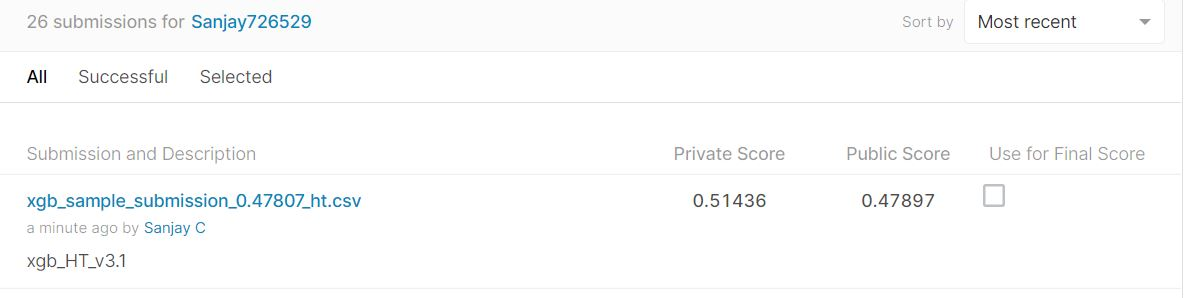

### Model6:  AdaBoost

In [10]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

# hyper parameter tuning
ada_param = dict(
            n_estimators = [5, 10, 50, 100, 250, 500, 1000],
            learning_rate = [0.001, 0.01, 0.1, 0.003, 0.03]
)

dt = DecisionTreeRegressor(max_depth=10)
adaregr = AdaBoostRegressor(base_estimator=dt, random_state=0)


rand_search = RandomizedSearchCV(estimator=adaregr,
                      param_distributions=ada_param,
                      n_jobs= -1,
                      cv=4,
                      scoring=rmsle_scorer,
                      verbose=10,
                      return_train_score=True)



In [11]:
rand_search.fit(x_tr.values, y_tr.values.reshape(-1))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 77.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 142.6min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 146.6min remaining: 48.9min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 156.4min remaining: 22.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 159.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 159.1min finished


RandomizedSearchCV(cv=4,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                                               random_state=0),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.003, 0.03],
                                        'n_estimators': [5, 10, 50, 100, 250,
                                                         500, 1000]},
                   return_train_score=True,
                   scoring=make_scorer(rmsle, greater_is_better=False),
                   verbose=10)

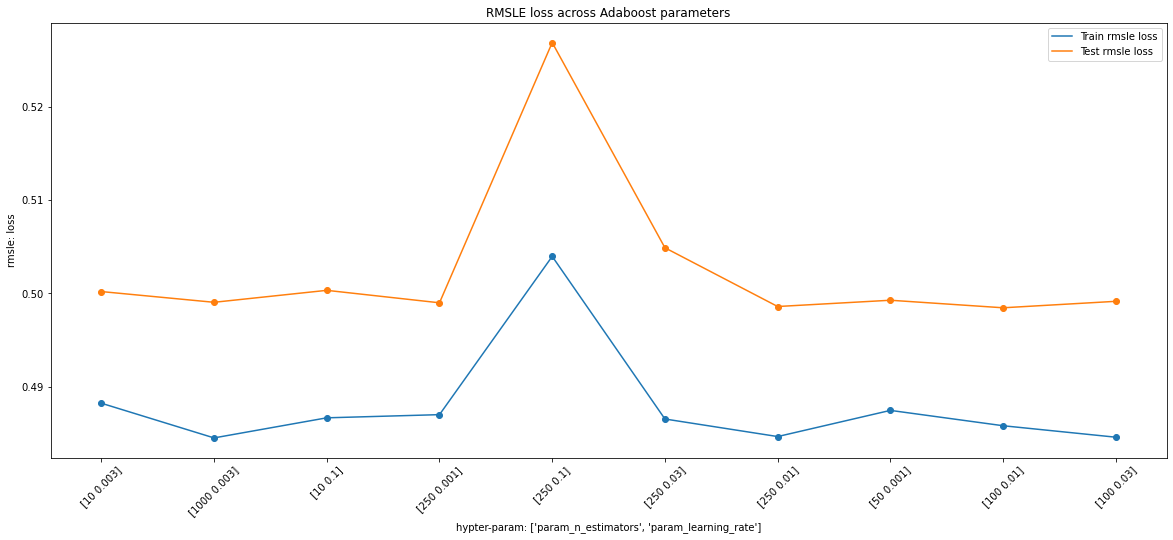

In [14]:
# if os.path.isfile(results_path + "/ada_cv_results.csv"):
#     ada_cv_results = pd.read_csv(results_path + "/ada_cv_results.csv")
# else:
ada_cv_results = pd.DataFrame(rand_search.cv_results_)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

mean_train_score = ada_cv_results.mean_train_score.values
mean_test_score = ada_cv_results.mean_test_score
params = [ str(row.values) for index, row in ada_cv_results[['param_n_estimators', 'param_learning_rate']].iterrows()]

plt.plot(range(len(params)), ada_cv_results.mean_train_score * -1, 
             label="Train rmsle loss")
plt.plot(range(len(params)), ada_cv_results.mean_test_score * -1, 
             label="Test rmsle loss")
plt.scatter(range(len(params)), ada_cv_results.mean_train_score * -1)
plt.scatter(range(len(params)), ada_cv_results.mean_test_score * -1)
plt.xticks(range(len(params)), labels = params, rotation=45)
plt.legend()
plt.xlabel("hypter-param: ['param_n_estimators', 'param_learning_rate']")
plt.ylabel("rmsle: loss")
plt.title("RMSLE loss across Adaboost parameters")
plt.show()

#### training with best ada estimator

In [15]:
adaregr = rand_search.best_estimator_

adaregr.fit(x_tr.values, y_tr.values.reshape(-1))

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                  learning_rate=0.01, n_estimators=100, random_state=0)

In [16]:
ada_val_predictions = adaregr.predict(x_val)

print("RMSLE score: ADABoost-regression: ", rmsle(y_val.values, ada_val_predictions))

RMSLE score: RF-regression:  0.5014850360567017


#### training for submission data: adaboost

In [17]:
# best rf estimator
adaregr = rand_search.best_estimator_

adaregr.fit(np.r_[x_tr.values, x_val.values], np.r_[y_tr.values, y_val.values])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                  learning_rate=0.01, n_estimators=100, random_state=0)

In [21]:
adab_test_predictions = adaregr.predict(x_test)

sample_submission = pd.read_csv(data_path + "/sample_submission.csv")
sample_submission.visitors = np.expm1(adab_test_predictions)

In [24]:
# save the xgb results
sample_submission.to_csv(results_path + f"/ada_boost_sample_submission_{rmsle(y_val.values, ada_val_predictions):.5f}.csv", index=False)

sample_submission_2 = holiday_trick(sample_submission)
sample_submission_2.to_csv(results_path + f"/ada_boost_sample_submission_{rmsle(y_val.values, ada_val_predictions):.5f}_ht.csv", float_format='%.5f', index=False)

ada_cv_results.to_csv(results_path + f"/ada_boost_cv_results_{rmsle(y_val.values, ada_val_predictions):.5f}.csv", index=False)

with open(results_path + f"/ada_boost_regression_{rmsle(y_val.values, ada_val_predictions):.5f}.pickle", 'wb') as f:
    pickle.dump(adaregr, f)

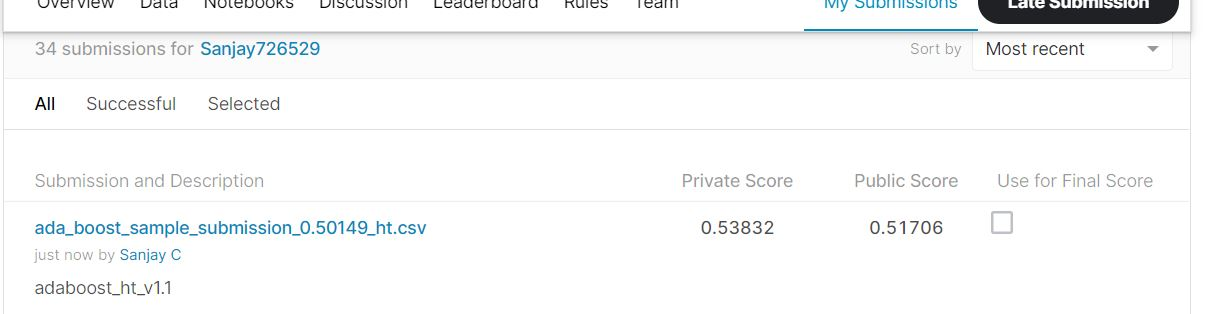

## Neural Network Methods

#### MLP

In [10]:
def dl_rmsle(y_true, y_pred):
    """
    This function will calculate the RMSLE score given the predicition and true values
    """

    # get exp of log predictions
    y_pred = tf.math.expm1(y_pred)
    y_true = tf.math.expm1(y_true)

    # calculate the rmsle
    # formula 
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(tf.math.log1p(y_true) - tf.math.log1p(y_pred))))

dl_rmsle_scorer = make_scorer(score_func=dl_rmsle, greater_is_better=False)

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from  tensorflow.keras import layers


# tune the architechture
def build_model(hp):
    # build
    model = Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=16,
                                        max_value=96,
                                        step=16),
                           activation='relu',
                          input_shape=(x_tr_std.shape[1],)))
    
    model.add(layers.Dropout(rate=hp.Choice('rate', values=[0.2, 0.3, 0.4, 0.5])))
    
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=16,
                                        max_value=96,
                                        step=16),
                           activation='relu'))

    model.add(layers.Dropout(rate=hp.Choice('rate', values=[0.2, 0.3, 0.4, 0.5])))

    model.add(layers.Dense(units=1))
    
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=dl_rmsle)
              
    return model

In [12]:
from kerastuner.tuners import RandomSearch
import kerastuner as kt

tuner = RandomSearch(
    build_model,
    objective=kt.Objective("val_dl_rmsle", direction="min"),
    max_trials=8,
    executions_per_trial=2,
    directory='deeplearning',
    project_name='RRVF')

INFO:tensorflow:Reloading Oracle from existing project deeplearning\RRVF\oracle.json
INFO:tensorflow:Reloading Tuner from deeplearning\RRVF\tuner0.json


In [13]:
tuner.search(x_tr_std, y_tr,
             epochs=3,
             batch_size=32,
             validation_data=(x_val_std, y_val))

INFO:tensorflow:Oracle triggered exit


In [14]:
mlp = tuner.get_best_models(num_models=1)[0]
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                4704      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa

early = tf.keras.callbacks.EarlyStopping(monitor='val_dl_rmsle', patience=3)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

callback = [early]

mlp.fit(x_tr_std, y_tr,
        epochs=50,
        batch_size=32,
        callbacks=callback,
        verbose=1,
        validation_data=(x_val_std, y_val))

Epoch 1/50
7386/7386 [=========================] - ETA: 0s - loss: 0.2771 - dl_rmsle: 0.526 - 6s 839us/step - loss: 0.2719 - dl_rmsle: 0.5147 - val_loss: 0.2655 - val_dl_rmsle: 0.4969
Epoch 2/50
7386/7386 [=========================] - ETA: 0s - loss: 0.2996 - dl_rmsle: 0.547 - 6s 825us/step - loss: 0.2614 - dl_rmsle: 0.5045 - val_loss: 0.2658 - val_dl_rmsle: 0.4991
Epoch 3/50
7386/7386 [=========================] - ETA: 0s - loss: 0.1442 - dl_rmsle: 0.379 - 6s 836us/step - loss: 0.2583 - dl_rmsle: 0.5014 - val_loss: 0.2839 - val_dl_rmsle: 0.5178
Epoch 4/50
7386/7386 [=========================] - ETA: 7s - loss: 0.2803 - dl_rmsle: 0.529 - 6s 799us/step - loss: 0.2562 - dl_rmsle: 0.4991 - val_loss: 0.2715 - val_dl_rmsle: 0.5039


In [19]:
mlp_val_predictions = mlp.predict(x_val_std)

print("RMSLE score: RF-regression: ", rmsle(y_val.values, mlp_val_predictions.reshape(-1)))

RMSLE score: RF-regression:  0.5166217998793975


#### training for submission data: MLP

In [17]:
mlp = tuner.get_best_models(num_models=1)[0]

early = tf.keras.callbacks.EarlyStopping(monitor='dl_rmsle', patience=3)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

callback = [early]

mlp.fit(np.r_[x_tr_std, x_val_std], np.r_[y_tr.values, y_val.values],
        epochs=10,
        verbose=1,
        batch_size=32,
        callbacks=callback)

Epoch 1/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2800 - dl_rmsle: 0.529 - ETA: 0s - loss: 0.2711 - dl_rmsle: 0.514 - 6s 767us/step - loss: 0.2712 - dl_rmsle: 0.5140
Epoch 2/10
7879/7879 [=========================] - ETA: 7s - loss: 0.2897 - dl_rmsle: 0.538 - 6s 741us/step - loss: 0.2622 - dl_rmsle: 0.5051
Epoch 3/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2650 - dl_rmsle: 0.514 - 6s 760us/step - loss: 0.2590 - dl_rmsle: 0.5019
Epoch 4/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2533 - dl_rmsle: 0.503 - ETA: 0s - loss: 0.2566 - dl_rmsle: 0.499 - 6s 819us/step - loss: 0.2567 - dl_rmsle: 0.4997
Epoch 5/10
7879/7879 [=========================] - ETA: 0s - loss: 0.3012 - dl_rmsle: 0.548 - 6s 758us/step - loss: 0.2548 - dl_rmsle: 0.4980
Epoch 6/10
7879/7879 [=========================] - ETA: 7s - loss: 0.2222 - dl_rmsle: 0.471 - 6s 760us/step - loss: 0.2540 - dl_rmsle: 0.4971
Epoch 7/10
7879/7879 [=========================] - ETA: 0s - l

In [149]:
mlp_test_predictions = mlp.predict(x_test_std)

sample_submission = pd.read_csv(data_path + "/sample_submission.csv")
sample_submission.visitors = np.expm1(mlp_test_predictions)

In [150]:
sample_submission.to_csv(results_path + f"/mlp_sample_submission_{rmsle(y_val.values, mlp_val_predictions.reshape(-1)):.5f}.csv", index=False)

sample_submission_2 = holiday_trick(sample_submission)
sample_submission_2.to_csv(results_path + f"/mlp_sample_submission_{rmsle(y_val.values, mlp_val_predictions.reshape(-1)):.5f}_ht.csv", float_format='%.5f', index=False)

mlp.save(results_path + f"/mlp_regression_{rmsle(y_val.values, mlp_val_predictions.reshape(-1)):.5f}.h5")
# with open(results_path + f"/mlp_regression_{rmsle(y_val.values, mlp_val_predictions):.5f}.pickle", 'wb') as f:
#     pickle.dump(mlp, f)

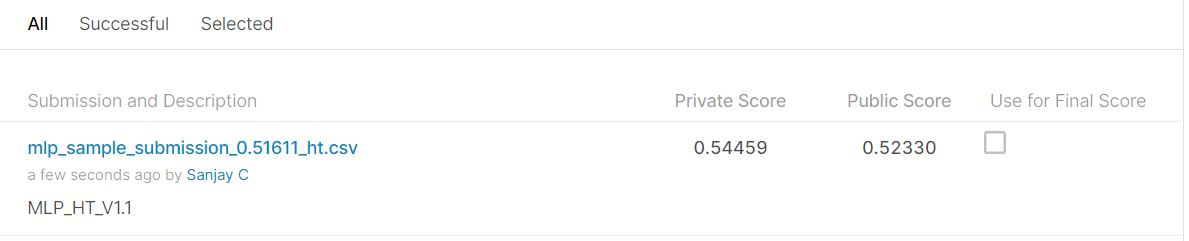

### LSTM

In [18]:
# reshape input
x_tr_lstm = x_tr_std.reshape(x_tr_std.shape[0], 1, x_tr_std.shape[1])
x_val_lstm = x_val_std.reshape(x_val_std.shape[0], 1, x_val_std.shape[1])
x_test_lstm = x_test_std.reshape(x_test_std.shape[0], 1, x_test_std.shape[1])

print("x_train: ", x_tr_lstm.shape)
print("x_val: ", x_val_lstm.shape)
print("x_test: ", x_test_lstm.shape)

x_train:  (236338, 1, 146)
x_val:  (15770, 1, 146)
x_test:  (32019, 1, 146)


In [19]:
import tensorflow as tf
from tensorflow.keras import Sequential
from  tensorflow.keras import layers


# tune the architechture
def build_model_lstm(hp):
    
    # build
    model = Sequential()
    model.add(layers.LSTM(units=hp.Int('units',
                                        min_value=5,
                                        max_value=100,
                                        step=10),
                            activation='relu',
                          input_shape=(x_tr_lstm.shape[1], x_tr_lstm.shape[2])))
    
    model.add(layers.Dense(units=1))
    
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=dl_rmsle)
              
    return model

In [20]:
from kerastuner.tuners import RandomSearch
import kerastuner as kt

tuner = RandomSearch(
    build_model_lstm,
    objective=kt.Objective("val_dl_rmsle", direction="min"),
    max_trials=8,
    executions_per_trial=3,
    directory='deeplearning_lstm',
    project_name='RRVF')

INFO:tensorflow:Reloading Oracle from existing project deeplearning_lstm\RRVF\oracle.json
INFO:tensorflow:Reloading Tuner from deeplearning_lstm\RRVF\tuner0.json


In [21]:
tuner.search(x_tr_lstm, y_tr.values,
             epochs=3,
             batch_size=32,
             validation_data=(x_val_lstm, y_val.values))

INFO:tensorflow:Oracle triggered exit


In [22]:
lstm_model = tuner.get_best_models(num_models=1)[0]
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                9720      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 9,736
Trainable params: 9,736
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early = tf.keras.callbacks.EarlyStopping(monitor='val_dl_rmsle', patience=3)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

callback = [early]

lstm_model.fit(x_tr_lstm, y_tr.values,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=callback,
        validation_data=(x_val_lstm, y_val.values))

Epoch 1/50
7386/7386 [=========================] - ETA: 0s - loss: 0.1344 - dl_rmsle: 0.366 - ETA: 1s - loss: 0.2349 - dl_rmsle: 0.477 - 8s 1ms/step - loss: 0.2348 - dl_rmsle: 0.4774 - val_loss: 0.2671 - val_dl_rmsle: 0.4976
Epoch 2/50
7386/7386 [=========================] - ETA: 0s - loss: 0.1265 - dl_rmsle: 0.355 - ETA: 1s - loss: 0.2321 - dl_rmsle: 0.474 - 8s 1ms/step - loss: 0.2328 - dl_rmsle: 0.4756 - val_loss: 0.2611 - val_dl_rmsle: 0.4936
Epoch 3/50
7386/7386 [=========================] - ETA: 0s - loss: 0.1733 - dl_rmsle: 0.416 - ETA: 1s - loss: 0.2312 - dl_rmsle: 0.473 - 8s 1ms/step - loss: 0.2314 - dl_rmsle: 0.4741 - val_loss: 0.2635 - val_dl_rmsle: 0.4955
Epoch 4/50
7386/7386 [=========================] - ETA: 0s - loss: 0.2269 - dl_rmsle: 0.476 - ETA: 1s - loss: 0.2296 - dl_rmsle: 0.472 - 8s 1ms/step - loss: 0.2301 - dl_rmsle: 0.4727 - val_loss: 0.2658 - val_dl_rmsle: 0.4962
Epoch 5/50
7386/7386 [=========================] - ETA: 0s - loss: 0.1769 - dl_rmsle: 0.420 - ETA: 1

In [39]:
lstm_val_predictions = lstm_model.predict(x_val_lstm)

print("RMSLE score: RF-regression: ", rmsle(y_val.values, lstm_val_predictions.reshape(-1)))

RMSLE score: RF-regression:  0.5172872672233108


#### training for the submission data: LSTM

In [25]:
lstm_model = tuner.get_best_models(num_models=1)[0]

early = tf.keras.callbacks.EarlyStopping(monitor='dl_rmsle', patience=3)

callback = [early]

lstm_model.fit(np.r_[x_tr_lstm, x_val_lstm], np.r_[y_tr.values, y_val.values],
        epochs=10,
        verbose=1,
        batch_size=32,
        callbacks=callback)

Epoch 1/10
7879/7879 [=========================] - ETA: 0s - loss: 0.4059 - dl_rmsle: 0.637 - ETA: 1s - loss: 0.2403 - dl_rmsle: 0.483 - 8s 991us/step - loss: 0.2395 - dl_rmsle: 0.4823
Epoch 2/10
7879/7879 [=========================] - ETA: 0s - loss: 0.1984 - dl_rmsle: 0.445 - ETA: 1s - loss: 0.2372 - dl_rmsle: 0.480 - 8s 991us/step - loss: 0.2367 - dl_rmsle: 0.4796
Epoch 3/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2953 - dl_rmsle: 0.543 - ETA: 1s - loss: 0.2351 - dl_rmsle: 0.477 - 8s 986us/step - loss: 0.2346 - dl_rmsle: 0.4772
Epoch 4/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2089 - dl_rmsle: 0.457 - ETA: 1s - loss: 0.2329 - dl_rmsle: 0.475 - 8s 984us/step - loss: 0.2331 - dl_rmsle: 0.4757
Epoch 5/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2947 - dl_rmsle: 0.542 - ETA: 1s - loss: 0.2317 - dl_rmsle: 0.474 - 8s 993us/step - loss: 0.2319 - dl_rmsle: 0.4745
Epoch 6/10
7879/7879 [=========================] - ETA: 0s - loss: 0.1452 -

In [137]:
lstm_test_predictions = lstm_model.predict(x_test_lstm)

sample_submission = pd.read_csv(data_path + "/sample_submission.csv")
sample_submission.visitors = np.expm1(lstm_test_predictions)

In [138]:
sample_submission.to_csv(results_path + f"/lstm_sample_submission_{rmsle(y_val.values, lstm_val_predictions.reshape(-1)):.5f}.csv", index=False)

sample_submission_2 = holiday_trick(sample_submission)
sample_submission_2.to_csv(results_path + f"/lstm_sample_submission_{rmsle(y_val.values, lstm_val_predictions.reshape(-1)):.5f}_ht.csv", float_format='%.5f', index=False)

lstm_model.save(results_path + f"/lstm_regression_{rmsle(y_val.values, lstm_val_predictions.reshape(-1)):.5f}.h5")
                
# with open(results_path + f"/lstm_regression_{rmsle(y_val.values, lstm_val_predictions):.5f}.pickle", 'wb') as f:
#     pickle.dump(lstm_model, f)

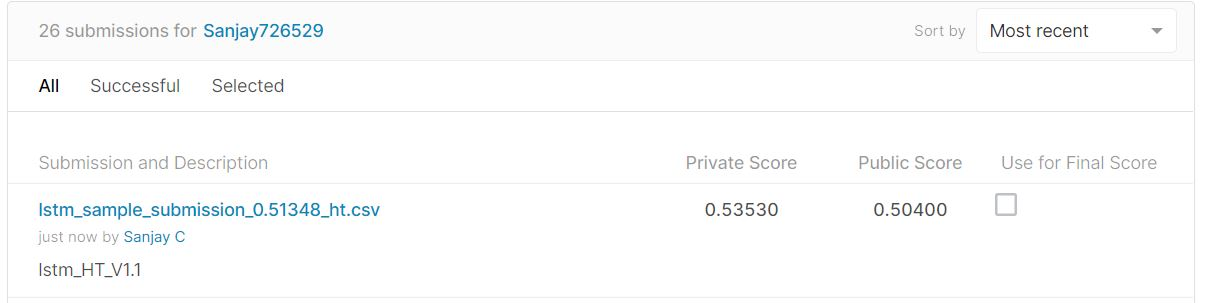

### CONV1D

In [26]:
# reshape input
x_tr_conv1d = x_tr_std.reshape(x_tr_std.shape[0], 1, x_tr_std.shape[1])
x_val_conv1d = x_val_std.reshape(x_val_std.shape[0], 1, x_val_std.shape[1])
x_test_conv1d = x_test_std.reshape(x_test_std.shape[0], 1, x_test_std.shape[1])

print("x_train: ", x_tr_conv1d.shape)
print("x_val: ", x_val_conv1d.shape)
print("x_test: ", x_test_conv1d.shape)

x_train:  (236338, 1, 146)
x_val:  (15770, 1, 146)
x_test:  (32019, 1, 146)


In [28]:
import tensorflow as tf
from tensorflow.keras import Sequential
from  tensorflow.keras import layers


# tune the architechture
def build_model_conv(hp):
    
    # build
    model = Sequential()
    model.add(layers.Conv1D(filters= hp.Int('conv1_units_1', min_value=10, max_value=100, step=10),
                            kernel_size=1,
                            activation='relu',
                            input_shape=x_tr_conv1d.shape[1:]))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=4, max_value=16, step=4), activation='relu'))
    model.add(layers.Dense(units=1))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=dl_rmsle)
   
    return model

In [29]:
# tune
from kerastuner.tuners import RandomSearch
import kerastuner as kt

conv_tuner = RandomSearch(
    build_model_conv,
    objective=kt.Objective("val_dl_rmsle", direction="min"),
    max_trials=8,
    executions_per_trial=3,
    directory='deeplearning_conv',
    project_name='RRVF')

INFO:tensorflow:Reloading Oracle from existing project deeplearning_conv\RRVF\oracle.json
INFO:tensorflow:Reloading Tuner from deeplearning_conv\RRVF\tuner0.json


In [30]:
conv_tuner.search(x_tr_conv1d, y_tr.values,
             epochs=3,
             batch_size=32,
             validation_data=(x_val_conv1d, y_val.values),
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [31]:
conv1d_model = conv_tuner.get_best_models(num_models=1)[0]
conv1d_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 20)             2940      
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 84        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 3,029
Trainable params: 3,029
Non-trainable params: 0
_________________________________________________________________


In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early = tf.keras.callbacks.EarlyStopping(monitor='val_dl_rmsle', patience=3)

callback = [early]

conv1d_model.fit(x_tr_conv1d, y_tr.values,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=callback,
        validation_data=(x_val_conv1d, y_val.values))

Epoch 1/50
7386/7386 [=========================] - ETA: 0s - loss: 0.1424 - dl_rmsle: 0.377 - 6s 809us/step - loss: 0.2403 - dl_rmsle: 0.4833 - val_loss: 0.2656 - val_dl_rmsle: 0.4980
Epoch 2/50
7386/7386 [=========================] - ETA: 0s - loss: 0.4948 - dl_rmsle: 0.703 - 6s 784us/step - loss: 0.2379 - dl_rmsle: 0.4807 - val_loss: 0.2648 - val_dl_rmsle: 0.4968
Epoch 3/50
7386/7386 [=========================] - ETA: 0s - loss: 0.2910 - dl_rmsle: 0.539 - 6s 826us/step - loss: 0.2360 - dl_rmsle: 0.4787 - val_loss: 0.2686 - val_dl_rmsle: 0.4993
Epoch 4/50
7386/7386 [=========================] - ETA: 0s - loss: 0.1500 - dl_rmsle: 0.387 - ETA: 0s - loss: 0.2345 - dl_rmsle: 0.477 - 7s 917us/step - loss: 0.2347 - dl_rmsle: 0.4774 - val_loss: 0.2657 - val_dl_rmsle: 0.4986
Epoch 5/50
7386/7386 [=========================] - ETA: 0s - loss: 0.3858 - dl_rmsle: 0.621 - 6s 819us/step - loss: 0.2337 - dl_rmsle: 0.4765 - val_loss: 0.2663 - val_dl_rmsle: 0.4979


In [48]:
conv1d_val_predictions = conv1d_model.predict(x_val_conv1d)

print("RMSLE score: RF-regression: ", rmsle(y_val.values, conv1d_val_predictions.reshape(-1)))

RMSLE score: RF-regression:  0.523006955188763


#### training for the submission data: Conv1D

In [33]:
conv1d_model = conv_tuner.get_best_models(num_models=1)[0]

early = tf.keras.callbacks.EarlyStopping(monitor='dl_rmsle', patience=3)

callback = [early]

conv1d_model.fit(np.r_[x_tr_conv1d, x_val_conv1d], np.r_[y_tr.values, y_val.values],
        epochs=10,
        verbose=1,
        batch_size=32,
        callbacks=callback)

Epoch 1/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2655 - dl_rmsle: 0.515 - 6s 738us/step - loss: 0.2417 - dl_rmsle: 0.4844
Epoch 2/10
7879/7879 [=========================] - ETA: 0s - loss: 0.3524 - dl_rmsle: 0.593 - 6s 712us/step - loss: 0.2389 - dl_rmsle: 0.4816
Epoch 3/10
7879/7879 [=========================] - ETA: 0s - loss: 0.1704 - dl_rmsle: 0.412 - 6s 715us/step - loss: 0.2372 - dl_rmsle: 0.4799
Epoch 4/10
7879/7879 [=========================] - ETA: 0s - loss: 0.1870 - dl_rmsle: 0.432 - 6s 730us/step - loss: 0.2360 - dl_rmsle: 0.4787
Epoch 5/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2576 - dl_rmsle: 0.507 - 6s 732us/step - loss: 0.2350 - dl_rmsle: 0.4777
Epoch 6/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2400 - dl_rmsle: 0.489 - 6s 711us/step - loss: 0.2340 - dl_rmsle: 0.4766
Epoch 7/10
7879/7879 [=========================] - ETA: 0s - loss: 0.2901 - dl_rmsle: 0.538 - 6s 761us/step - loss: 0.2333 - dl_rmsle: 0.4760
Epoch 

In [120]:
conv1d_test_predictions = conv1d_model.predict(x_test_conv1d)

sample_submission = pd.read_csv(data_path + "/sample_submission.csv")
sample_submission.visitors = np.expm1(conv1d_test_predictions)

In [123]:
sample_submission.to_csv(results_path + f"/conv1d_sample_submission_{rmsle(y_val.values, conv1d_val_predictions.reshape(-1)):.5f}.csv", index=False)

sample_submission_2 = holiday_trick(sample_submission)
sample_submission_2.to_csv(results_path + f"/conv1d_sample_submission_{rmsle(y_val.values, conv1d_val_predictions.reshape(-1)):.5f}_ht.csv", float_format='%.5f', index=False)


conv1d_model.save(results_path + f"/conv1d_regression_{rmsle(y_val.values, conv1d_val_predictions.reshape(-1)):.5f}.h5")
                
# with open(results_path + f"/lstm_regression_{rmsle(y_val.values, lstm_val_predictions):.5f}.pickle", 'wb') as f:
#     pickle.dump(lstm_model, f)

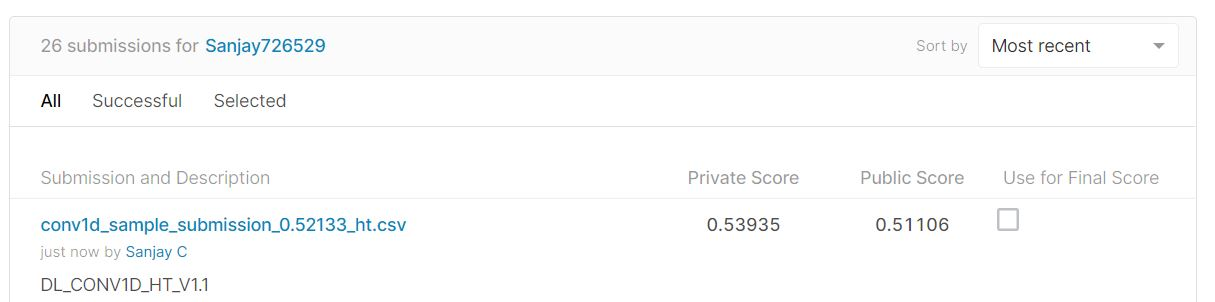

### Modeling: Summary

In [10]:
validation_rmsle_results = dict(REGRESSION_ALGORITHM =['KNN', 'SGD_LR', 'Decision Tree', 'Random Forest', 'XGboost', 'Adaboost', 'MLP', 'LSTM', 'Conv1D'],
                                RMSLE_VAL_SCORE = ['0.51938', '0.51276', '0.50471', '0.50035', '0.47826', '0.50148', '0.51611', '0.51728', '0.52300'])
hyper_parameters=['n_neighbours = 9', 'alpha=0.1', 'max_depth=10, min_samples_leaf=50, min_samples_split=500',
                                                    'max_depth=10, n_estimators=1000', '']
validation_rmsle_results = pd.DataFrame(validation_rmsle_results)
validation_rmsle_results

,REGRESSION_ALGORITHM,RMSLE_VAL_SCORE
0,KNN,0.51938
1,SGD_LR,0.51276
2,Decision Tree,0.50471
3,Random Forest,0.50035
4,XGboost,0.47826
5,Adaboost,0.50148
6,MLP,0.51611
7,LSTM,0.51728
8,Conv1D,0.52300


In [43]:
score = dict(algorithm = ['KNN', 'SGD_LR', 'Decision Tree', 'Random Forest', 'XGboost', 'Adaboost', 'MLP', 'LSTM', 'Conv1D'],
             private = [0.52590, 0.54318, 0.54322, 0.53769, 0.51436, 0.53838, 0.54459, 0.53530, 0.53935],
             public=[0.51330, 0.52212, 0.52114, 0.51478, 0.47897, 0.51706, 0.52330, 0.50400, 0.51106])

kaggle=pd.DataFrame(score)
kaggle

,algorithm,private,public
0,KNN,0.52590,0.51330
1,SGD_LR,0.54318,0.52212
2,Decision Tree,0.54322,0.52114
3,Random Forest,0.53769,0.51478
4,XGboost,0.51436,0.47897
5,Adaboost,0.53838,0.51706
6,MLP,0.54459,0.52330
7,LSTM,0.53530,0.50400
8,Conv1D,0.53935,0.51106


**Out of the all the algorithms tried, XGBoost yields the best private score**